* Objectif :    
    - Prédire si une personne est infectée en fonction des données cliniques disponibles
* Métrique adaptée choisie ? (ex : F1, Recall...)
    - F1 min 50% et recall min 70%

In [110]:
# Imports standards
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import ttest_ind

# Scikit-learn: model selection
from sklearn.model_selection import (
    GridSearchCV,
    cross_val_score,
    learning_curve,
    train_test_split,
    validation_curve,
)

# Scikit-learn: preprocessing
from sklearn.preprocessing import (
    Binarizer,
    KBinsDiscretizer,
    LabelEncoder,
    MinMaxScaler,
    OneHotEncoder,
    OrdinalEncoder,
    PolynomialFeatures,
    RobustScaler,
    StandardScaler,
)

# Scikit-learn: pipeline & composition
from sklearn.pipeline import make_pipeline, make_union
from sklearn.compose import make_column_selector, make_column_transformer

# Scikit-learn: imputation
from sklearn.impute import SimpleImputer

# Scikit-learn: feature selection
from sklearn.feature_selection import (
    RFECV,
    RFE,
    SelectFromModel,
    SelectKBest,
    VarianceThreshold,
    chi2,
    f_classif
)

# Scikit-learn: models
from sklearn.linear_model import LinearRegression, SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.cluster import KMeans
from sklearn.ensemble import (
    AdaBoostClassifier,
    BaggingClassifier,
    GradientBoostingClassifier,
    IsolationForest,
    RandomForestClassifier,
    StackingClassifier,
    VotingClassifier,
)

# Scikit-learn: decomposition
from sklearn.decomposition import PCA

# Scikit-learn: metrics
from sklearn.metrics import (
    confusion_matrix,
    mean_absolute_error,
    mean_squared_error,
    median_absolute_error,
    f1_score,
    classification_report
) 
pd.reset_option('display.max_rows')
pd.reset_option('display.max_columns')
pd.reset_option('display.width')
pd.reset_option('display.max_colwidth')

# EDA

## Form Analysis (EDA)

* [X]Ai-je identifié la variable cible (target) ?
    - target = data["SARS-Cov-2 exam result	"]

In [3]:
#Importe le dataset covid 19 et affichage des données du dataset
data = pd.read_csv("../data/covid-19.csv", encoding="latin1")
df = data.copy()
display(df) #Target = SARS-Cov-2 exam result


Patient ID  Patient age quantile SARS-Cov-2 exam result  \
0     44477f75e8169d2                    13               negative   
1     126e9dd13932f68                    17               negative   
2     a46b4402a0e5696                     8               negative   
3     f7d619a94f97c45                     5               negative   
4     d9e41465789c2b5                    15               negative   
...               ...                   ...                    ...   
5639  ae66feb9e4dc3a0                     3               positive   
5640  517c2834024f3ea                    17               negative   
5641  5c57d6037fe266d                     4               negative   
5642  c20c44766f28291                    10               negative   
5643  2697fdccbfeb7f7                    19               positive   

      Patient addmited to regular ward (1=yes, 0=no)  \
0                                                  0   
1                                                  0   
2                                                  0   
3                                                  0   
4                                                  0   
...                                              ...   
5639                                               0   
5640                                               0   
5641                                               0   
5642                                               0   
5643                                               0   

      Patient addmited to semi-intensive unit (1=yes, 0=no)  \
0                                                     0       
1                                                     0       
2                                                     0       
3                                                     0       
4                                                     0       
...                                                 ...       
5639                                                  0       
5640                                                  0       
5641                                                  0       
5642                                                  0       
5643                                                  0       

      Patient addmited to intensive care unit (1=yes, 0=no)  Hematocrit  \
0                                                     0             NaN   
1                                                     0        0.236515   
2                                                     0             NaN   
3                                                     0             NaN   
4                                                     0             NaN   
...                                                 ...             ...   
5639                                                  0             NaN   
5640                                                  0             NaN   
5641                                                  0             NaN   
5642                                                  0             NaN   
5643                                                  0        0.694287   

      Hemoglobin  Platelets  Mean platelet volume   ...  \
0            NaN        NaN                    NaN  ...   
1      -0.022340  -0.517413               0.010677  ...   
2            NaN        NaN                    NaN  ...   
3            NaN        NaN                    NaN  ...   
4            NaN        NaN                    NaN  ...   
...          ...        ...                    ...  ...   
5639         NaN        NaN                    NaN  ...   
5640         NaN        NaN                    NaN  ...   
5641         NaN        NaN                    NaN  ...   
5642         NaN        NaN                    NaN  ...   
5643    0.541564  -0.906829              -0.325903  ...   

      Hb saturation (arterial blood gases)  \
0                                      NaN   
1                                     

* [X]Ai-je noté le nombre de lignes et colonnes du dataset ?
    - (5644, 111)

In [4]:
df.shape

(5644, 111)

* [X] Les types de variables sont-ils bien identifiés (numériques, catégorielles...) ? (sns.pie and dtype with value_counts)
    - float64: 70, object: 37, int64: 4

**Tips**:
- (sns.pie and dtype with value_counts)

float64    70
object     37
int64       4
Name: count, dtype: int64


([<matplotlib.patches.Wedge at 0x22b27888f80>,
 [Text(-0.43886182859316464, 1.0086626271473846, 'float64'),
  Text(0.32210496057508803, -1.0517834351105368, 'object'),
  Text(1.0929583742237192, -0.12426581273320798, 'int64')],
 [Text(-0.23937917923263524, 0.5501796148076643, '63.1%'),
  Text(0.17569361485913892, -0.5737000555148383, '33.3%'),
  Text(0.5961591132129377, -0.06778135239993162, '3.6%')])

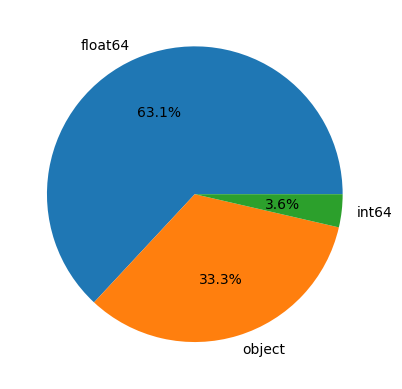

In [5]:
#Displays the types of variables in the dataset
print(df.dtypes.value_counts())
plt.pie(df.dtypes.value_counts(), labels=df.dtypes.value_counts().index, autopct='%1.1f%%')

* [X]Ai-je repéré les valeurs manquantes ? 
    - When there are lines in the heatmap, there are relations in the variables
    - 72 columns with missing value percentage over 90%
    - 2 groups: 76% => viral test, 89% taux sanguins

**Tips**:
   - with isna and sns.heatmap
   - IF yes => delete the columns with a too many of Nan values
   - Displays the percentage of missing values for findind groups in data

Pourcentage total de valeurs manquantes dans le dataset: 0.8806003026414082
Nombre de colonnes avec plus de 90% de valeurs manquantes: 72
Pourcentage de valeurs manquantes par colonne (triées):
Urine - Sugar                                            1.0
Mycoplasma pneumoniae                                    1.0
Partial thromboplastin time (PTT)                        1.0
Prothrombin time (PT), Activity                          1.0
D-Dimer                                                  1.0
                                                        ... 
SARS-Cov-2 exam result                                   0.0
Patient age quantile                                     0.0
Patient addmited to semi-intensive unit (1=yes, 0=no)    0.0
Patient addmited to intensive care unit (1=yes, 0=no)    0.0
Patient ID                                               0.0
Length: 111, dtype: float64


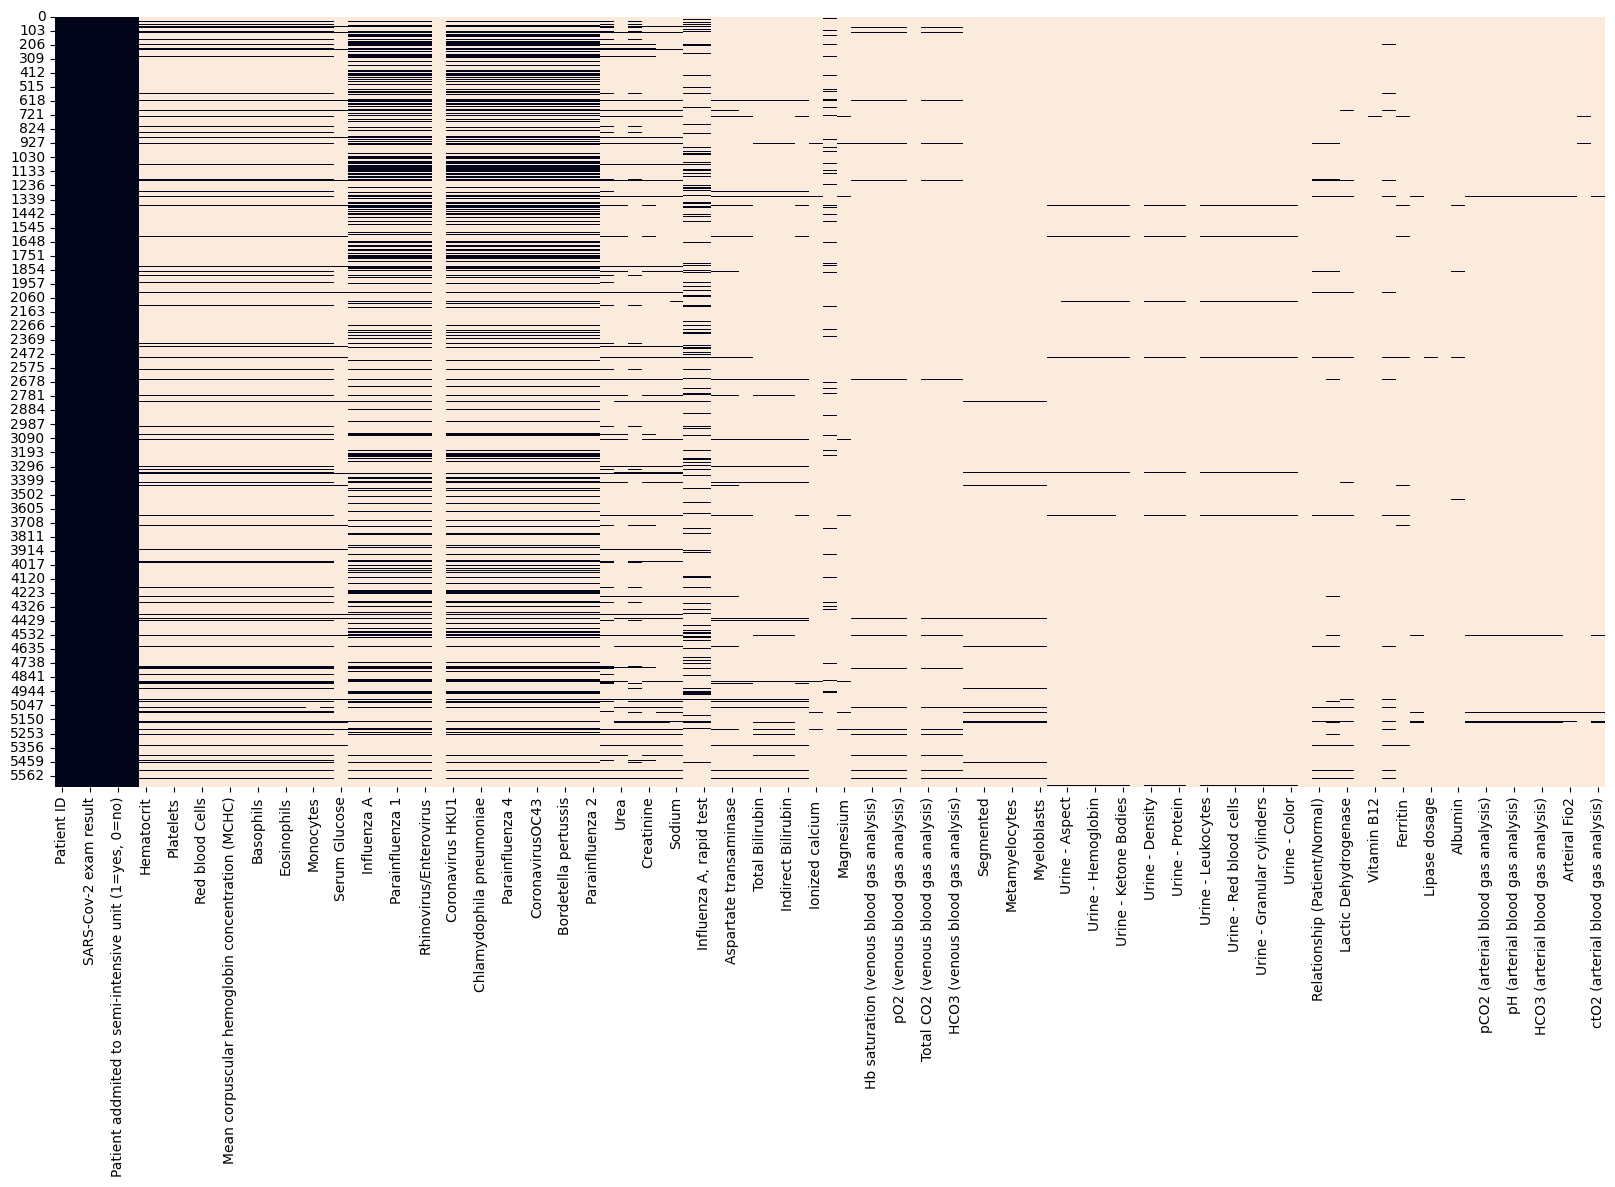

In [6]:
### By myself
plt.figure(figsize=(20, 10))
sns.heatmap(df.isna(), cbar=False)
print("Pourcentage total de valeurs manquantes dans le dataset:", (df.isna().sum()).sum() / (df.shape[0] * df.shape[1]))
print("Nombre de colonnes avec plus de 90% de valeurs manquantes:", ((df.isna().sum() / df.shape[0]) > 0.90).sum())
print("Pourcentage de valeurs manquantes par colonne (triées):")
missing_percentages = (df.isna().sum() / df.shape[0]).sort_values(ascending=False)
print(missing_percentages)

### Content analysis (EDA)
##### + nettoyage du df



In [7]:
df = df.loc[:, df.isna().sum()/df.shape[0] < 0.90]
df = df.drop("Patient ID", axis=1)  # Drop the "Patien ID" column as it is not useful for analysis

* Visualisation de la target (histogramme, boxplot) ?
    - 10% positive test => Classes pas équilibrées => utiliser score F1

**Tips**:
- (sns.pie and dtype with value_counts)

In [8]:
df["SARS-Cov-2 exam result"].value_counts(normalize=True)

SARS-Cov-2 exam result
negative    0.901134
positive    0.098866
Name: proportion, dtype: float64

* Significations des variables (Histogrammes de valeurs)?
    - Les courbes sont centrées en 0 avec écrat type = 1 => données standardisées
    - distribution normales pour la plupart
    - virale, variable qualitative binaire, rhinovirus qui semble très élevé

**Tips**:
- Utiliser .select_dtypes() pour sélectionner seulement un type de donnée
- Utiliser unique pour obtenir le type de variable(similaire à value_counts)
- Utiliser pie pour visualiser la distribution de chacune des colonnes

Variables quantitatives

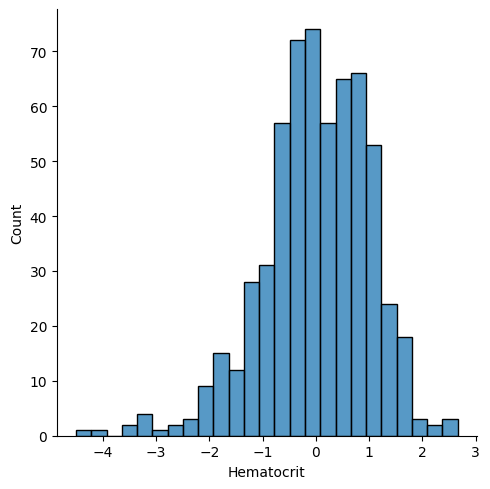

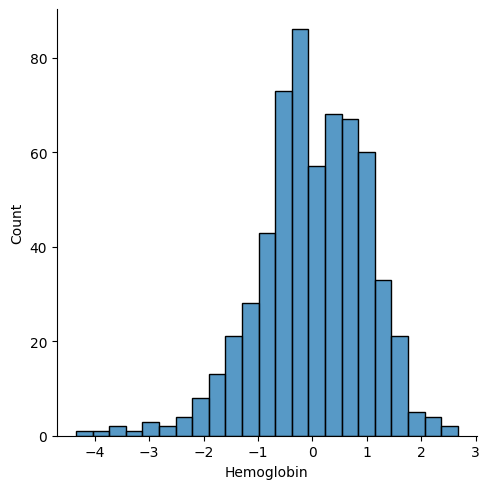

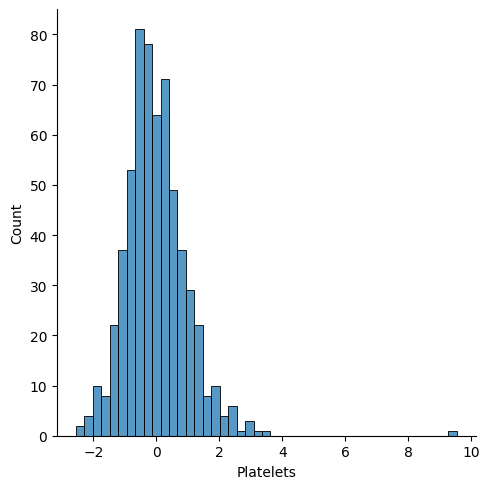

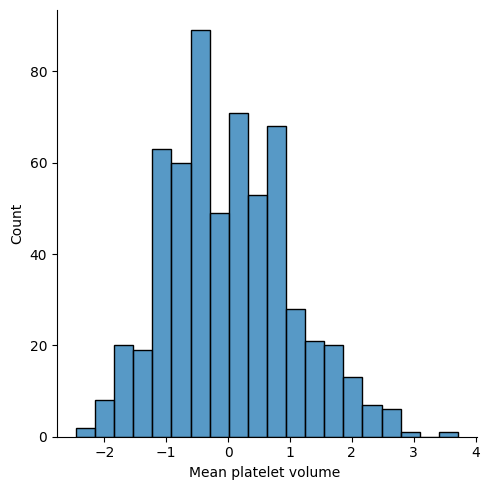

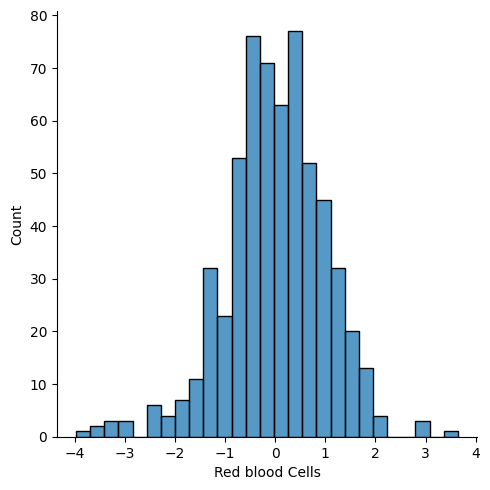

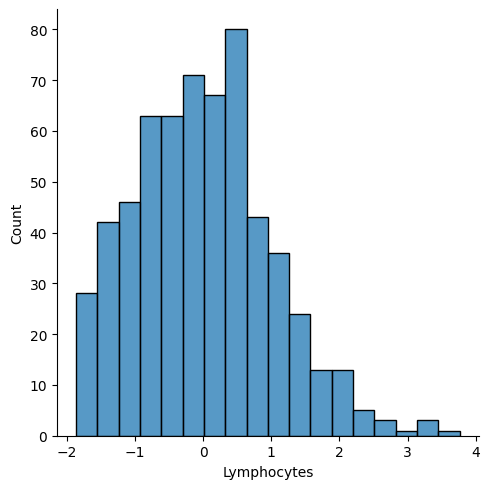

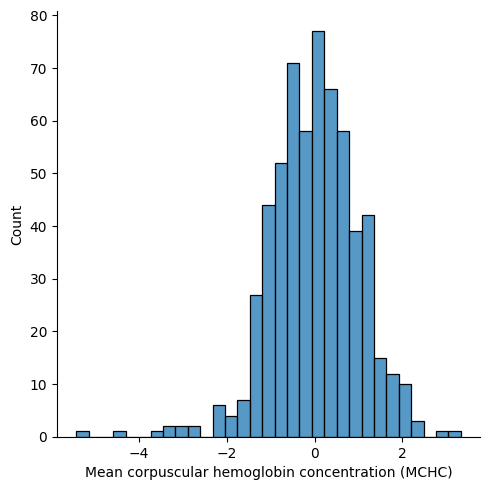

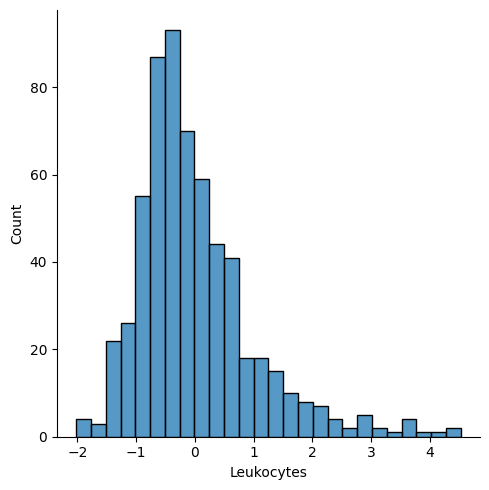

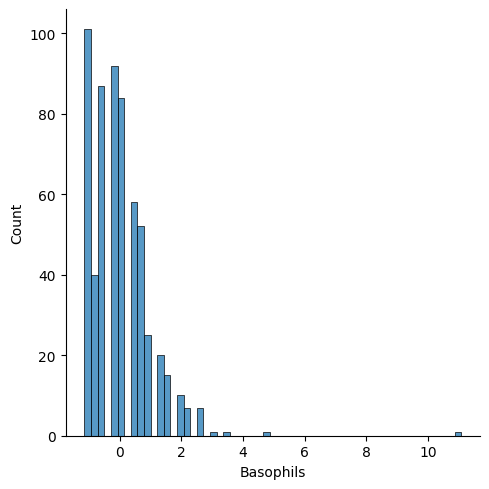

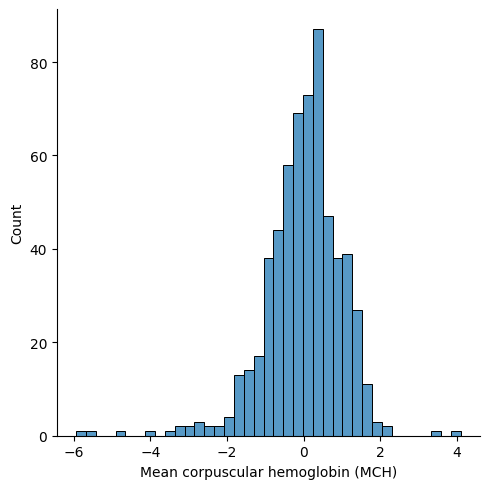

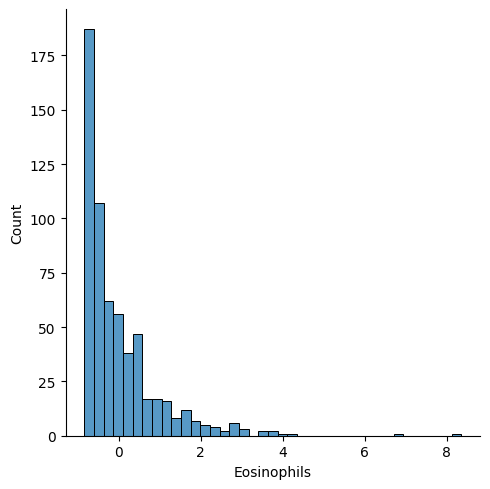

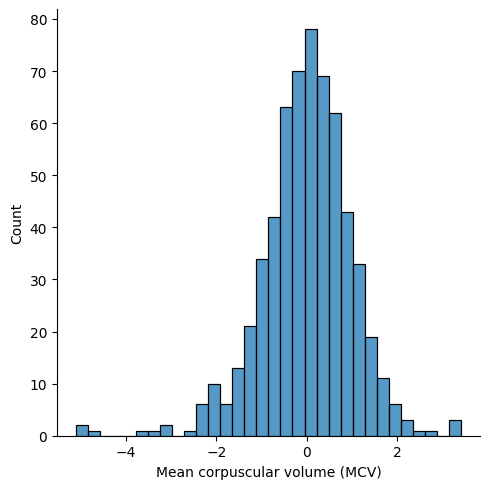

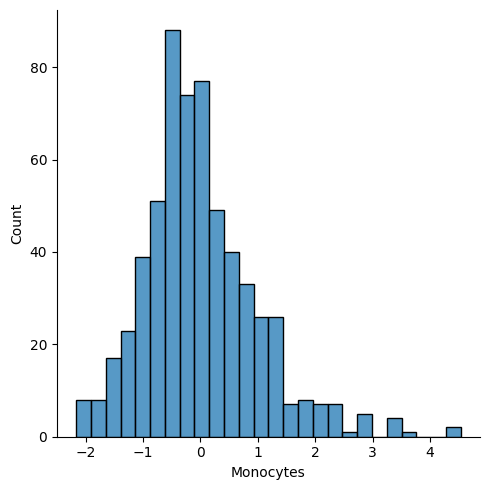

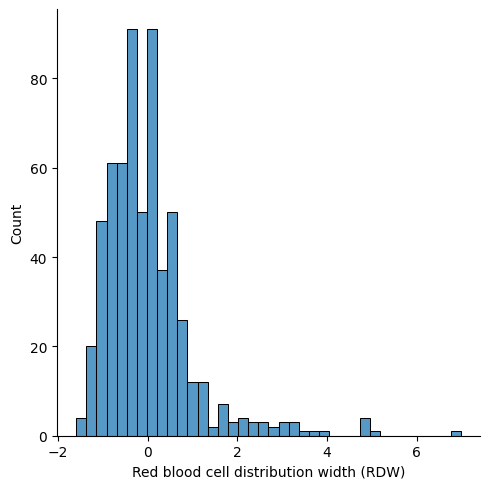

In [9]:

for col in df.select_dtypes("float"): # Loop through all float columns
    sns.displot(df[col])

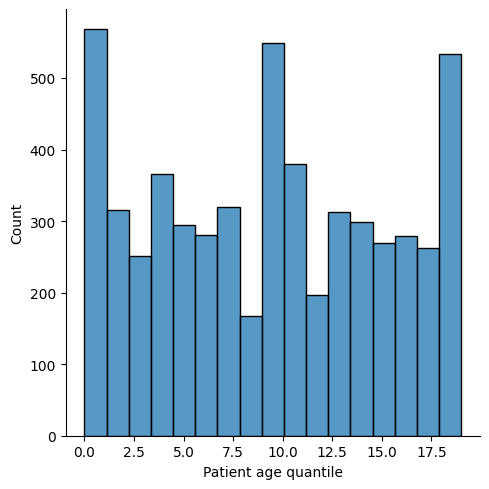

In [10]:
sns.displot(df["Patient age quantile"])

Variables Qualitatives

In [11]:
for col in df.select_dtypes("object"):
    print(f'{col :-<40} {df[col].unique()}')

SARS-Cov-2 exam result------------------ ['negative' 'positive']
Respiratory Syncytial Virus------------- [nan 'not_detected' 'detected']
Influenza A----------------------------- [nan 'not_detected' 'detected']
Influenza B----------------------------- [nan 'not_detected' 'detected']
Parainfluenza 1------------------------- [nan 'not_detected' 'detected']
CoronavirusNL63------------------------- [nan 'not_detected' 'detected']
Rhinovirus/Enterovirus------------------ [nan 'detected' 'not_detected']
Coronavirus HKU1------------------------ [nan 'not_detected' 'detected']
Parainfluenza 3------------------------- [nan 'not_detected' 'detected']
Chlamydophila pneumoniae---------------- [nan 'not_detected' 'detected']
Adenovirus------------------------------ [nan 'not_detected' 'detected']
Parainfluenza 4------------------------- [nan 'not_detected' 'detected']
Coronavirus229E------------------------- [nan 'not_detected' 'detected']
CoronavirusOC43------------------------- [nan 'not_detected

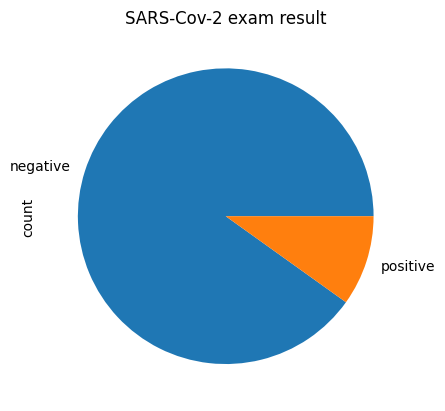

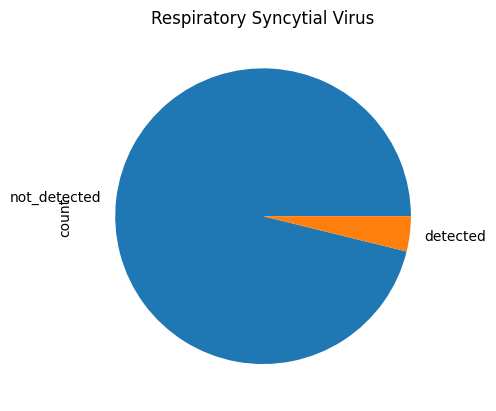

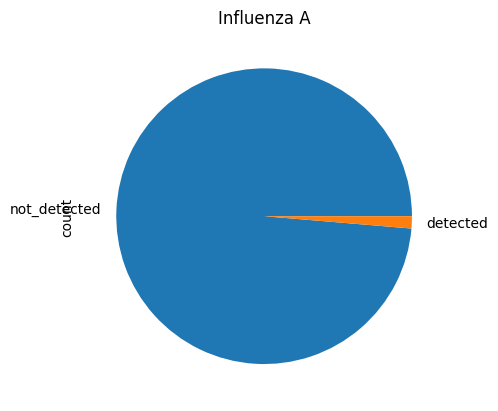

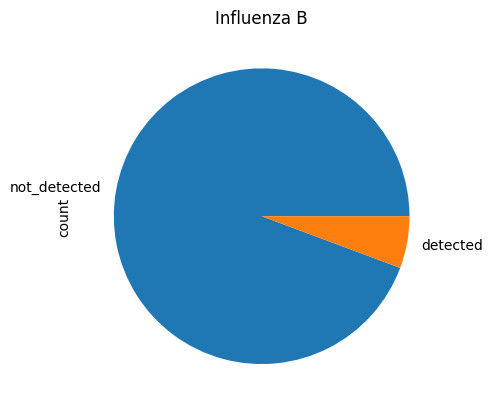

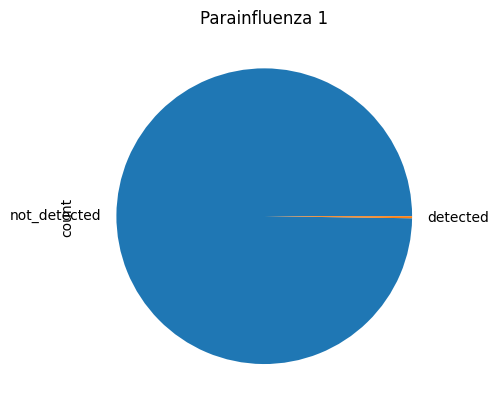

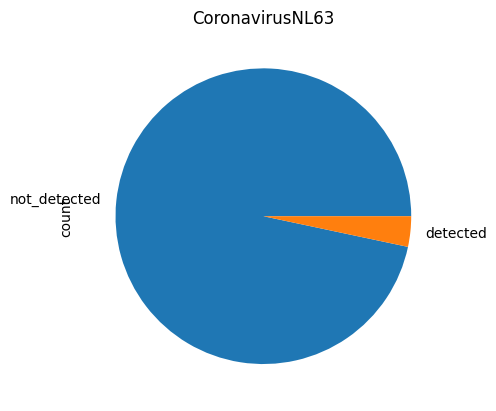

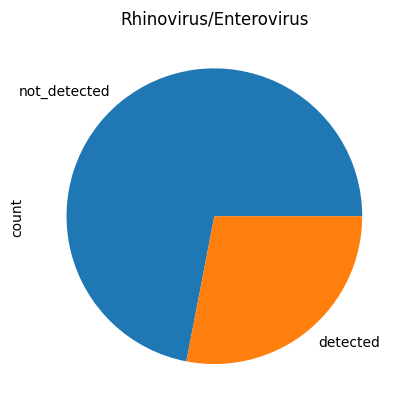

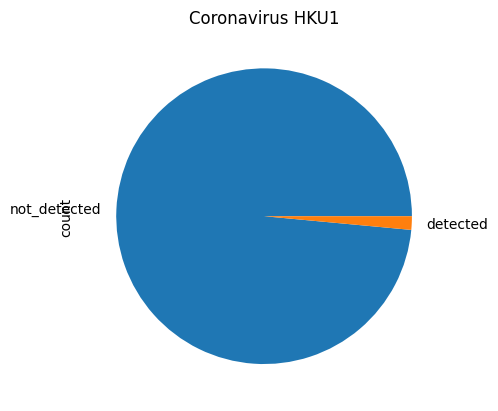

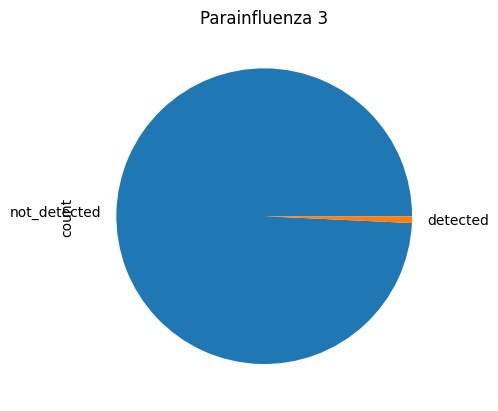

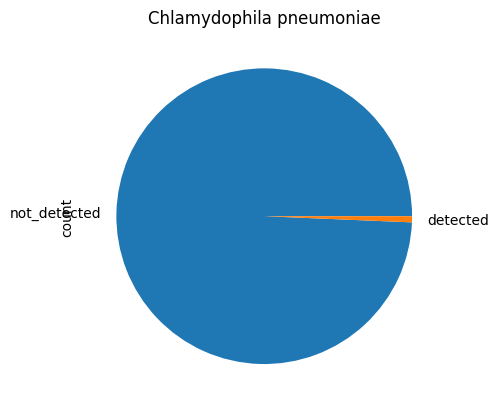

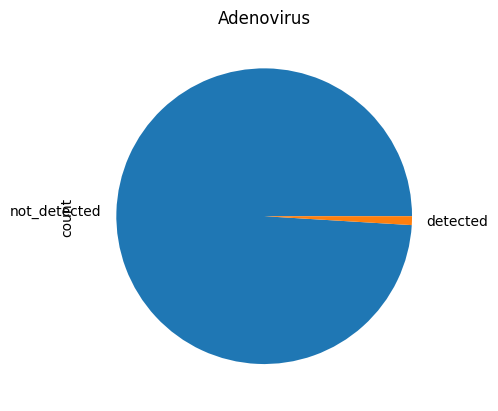

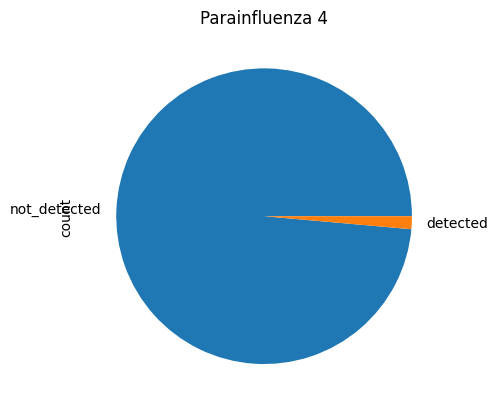

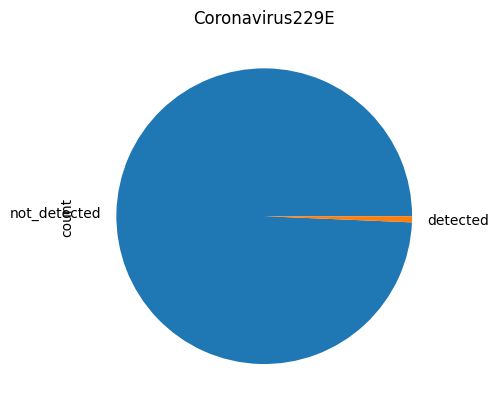

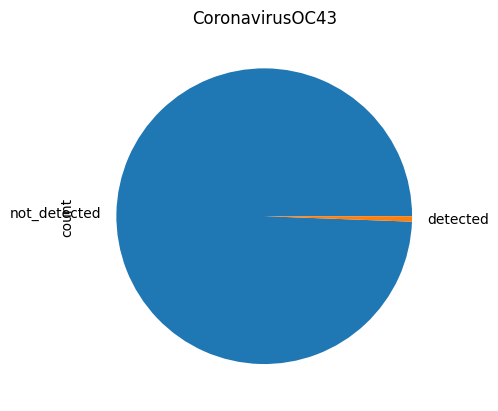

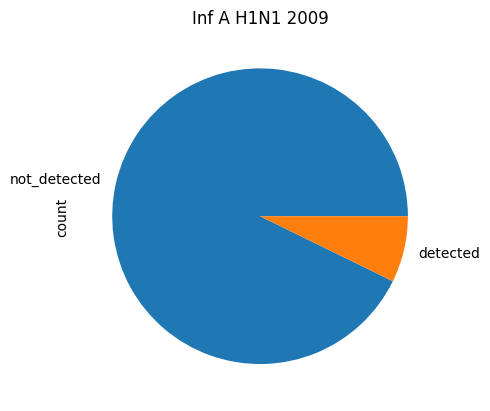

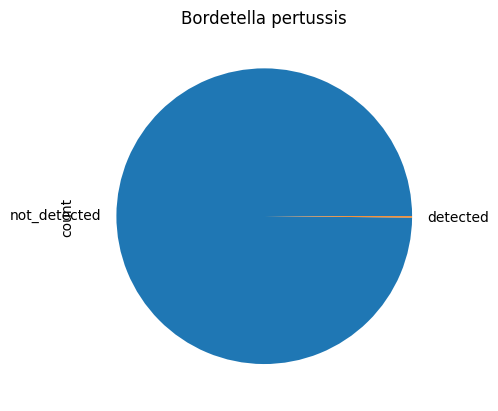

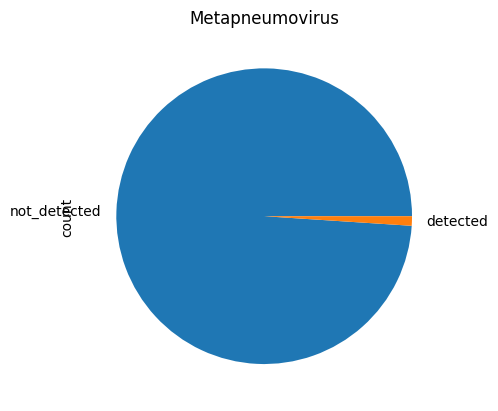

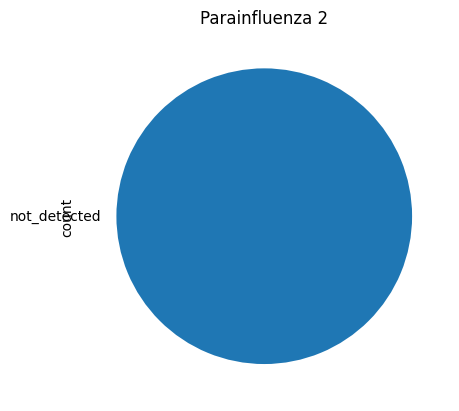

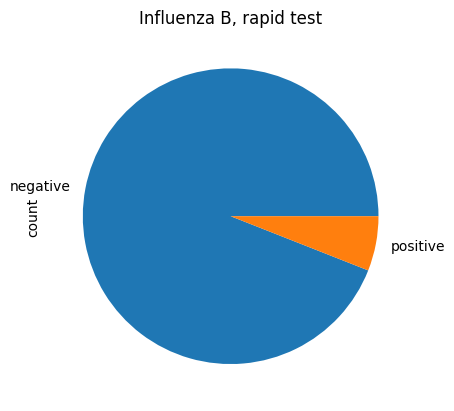

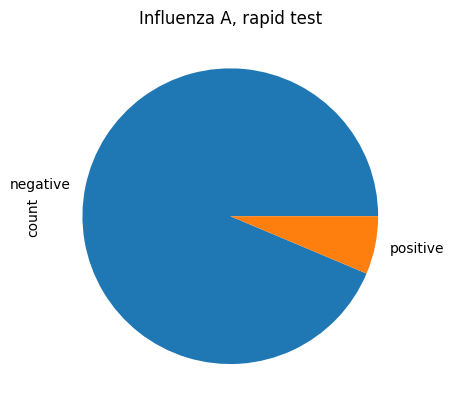

In [12]:
for col in df.select_dtypes("object"):
    plt.figure()
    df.value_counts(col).plot.pie()
    plt.title(col)

* Relation Target/Variables (histogrammes ...)?
    - blood/target: taux de Monocytes, PLatelets, Leukocytes semblent liés au covid => hypothèse à tester
    - targte/age: quand variable faible, très faible taux de contamination. ATTENTION: on ne connait pas la signification de la variable. Elle pourra être utile pour comparer avec tests sanguins
    - target/viral: double maladie très rare, quand Rhinovirus/Enterovirus positif, covid negatif MAIS pas sûr => à tester, suppression de la variable Parainfluenza 2 car il n'y a aucun cas détécté => on ne peut pas corréler cette maladie avec le covid 19

**Tips**:
- sns.histplot, displot, pairplot
- sns.countplot
- pd.crosstab

Création de sous ensembles positifs/négatifs et blood/viral

In [13]:
positive_df = df[df["SARS-Cov-2 exam result"] == "positive"]
negative_df = df[df["SARS-Cov-2 exam result"] == "negative"]
missing_rate = df.isna().sum() / df.shape[0]
blood_columns = df.columns[(missing_rate < 0.90) & (missing_rate > 0.89)]
viral_columns = df.columns[(missing_rate < 0.77) & (missing_rate > 0.76)]

print(f"blood_columns: {blood_columns.shape}")
print(f"viral_columns: {viral_columns.shape}")

blood_columns: (14,)
viral_columns: (17,)


Relations entre target/blood

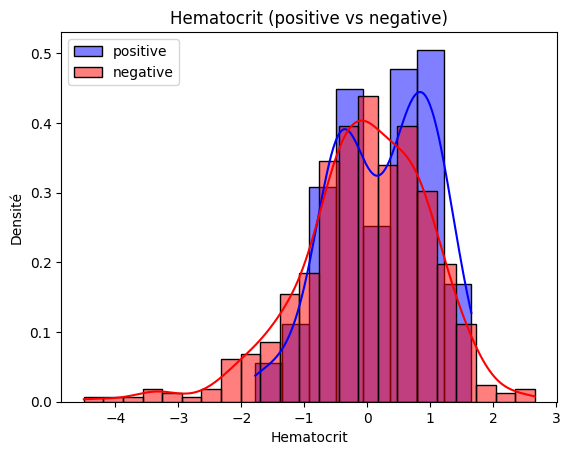

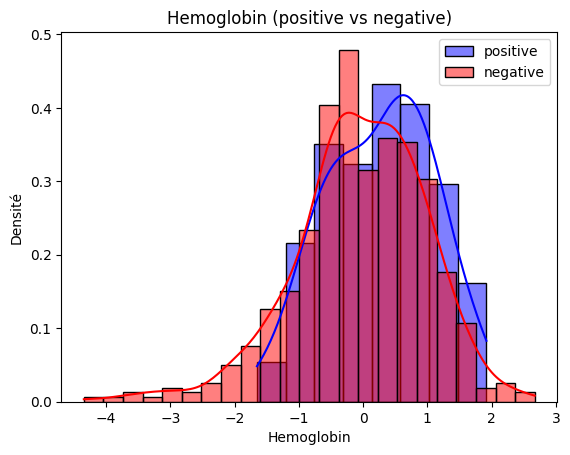

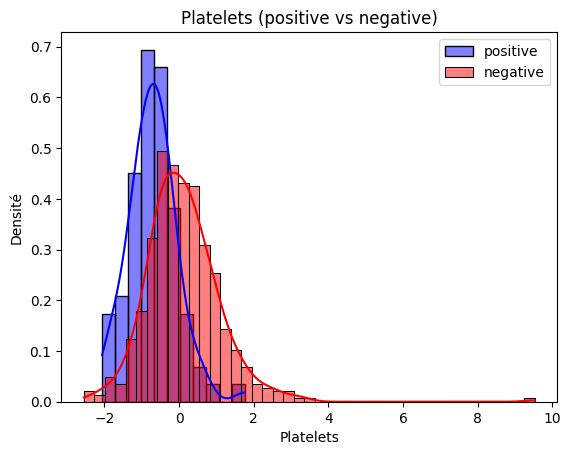

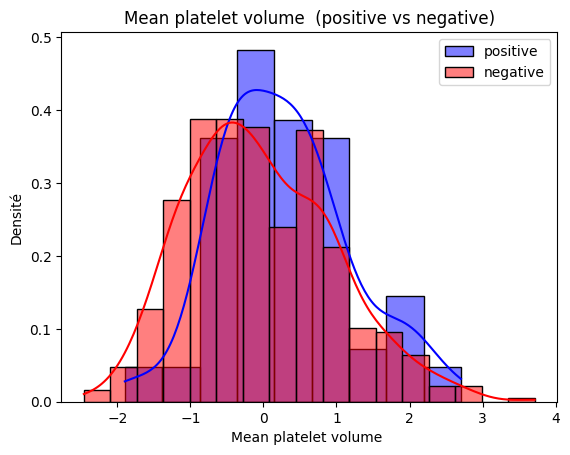

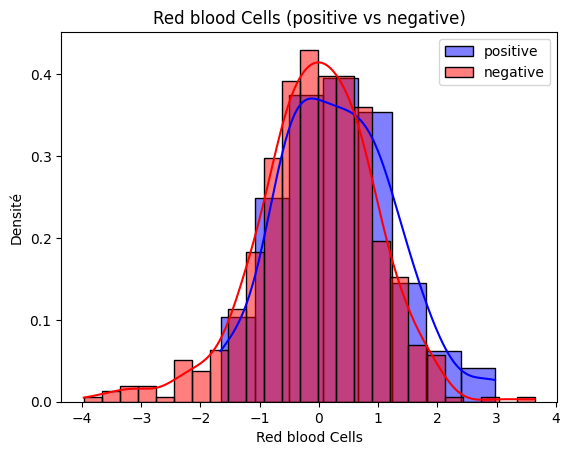

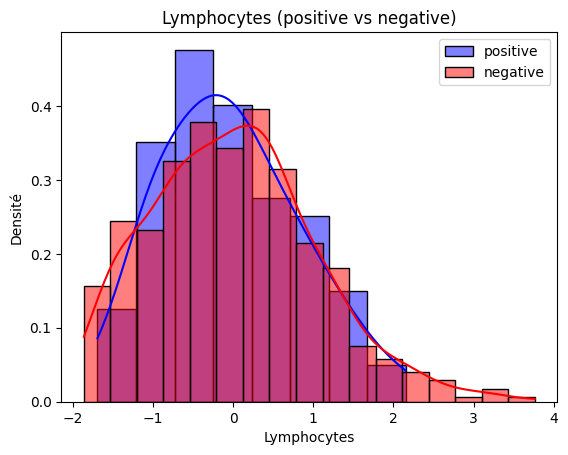

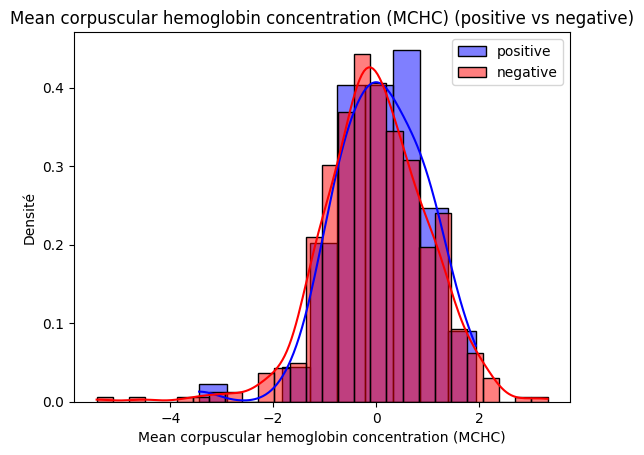

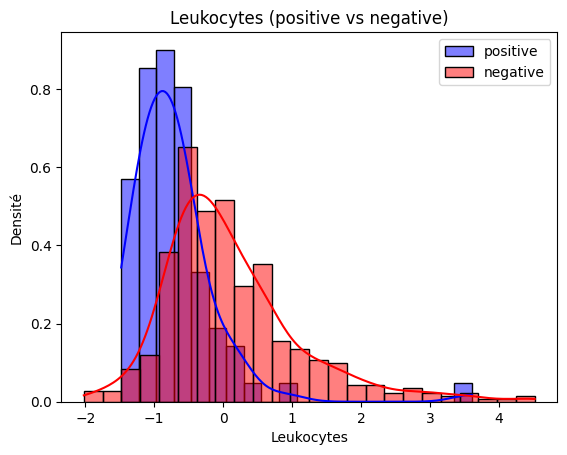

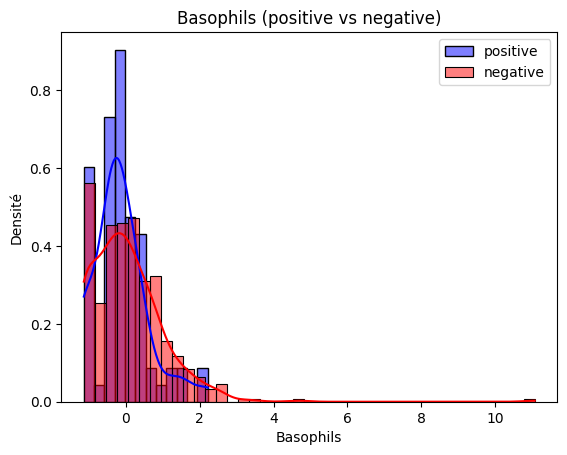

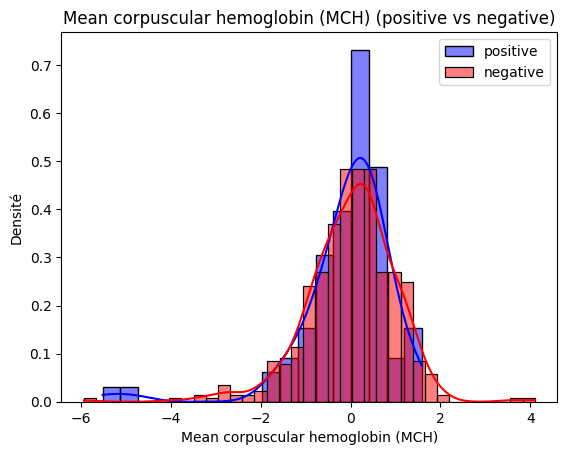

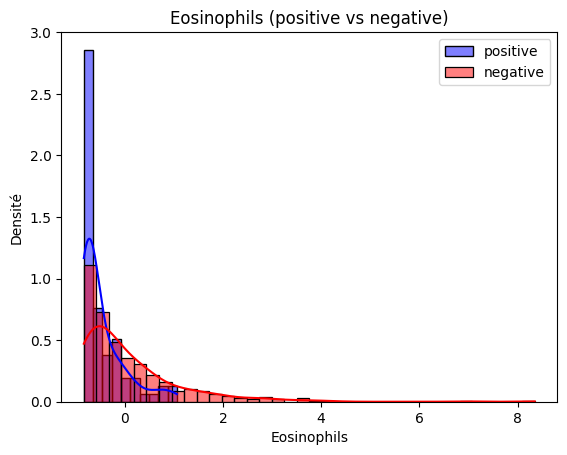

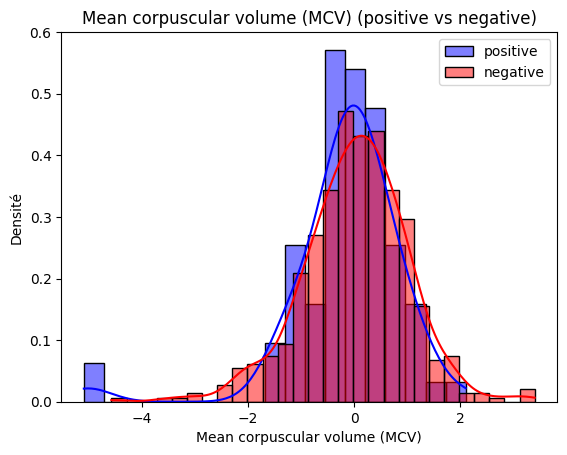

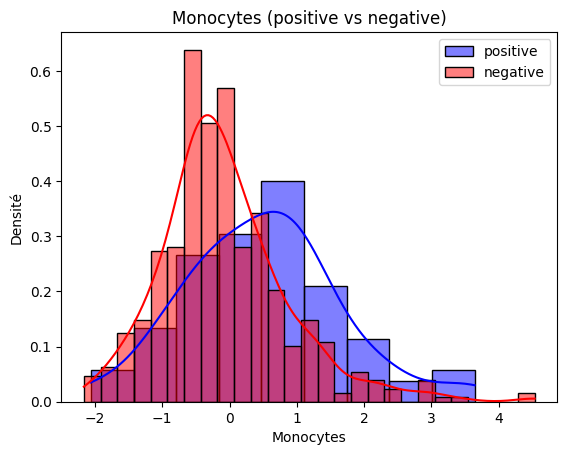

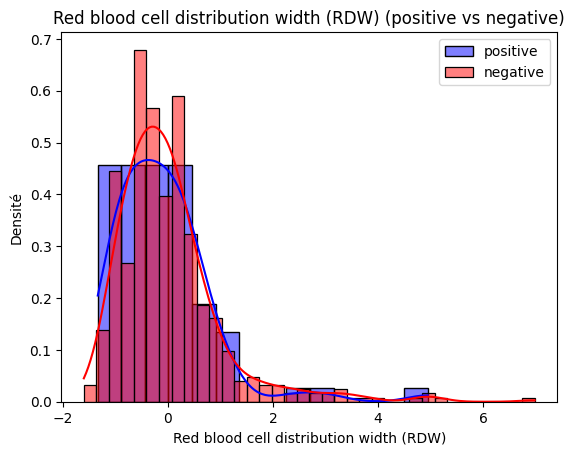

In [14]:
for col in blood_columns:
    plt.figure()
    sns.histplot(positive_df[col], label="positive", kde=True, alpha=0.5, color="blue", stat="density")
    sns.histplot(negative_df[col], label="negative", kde=True, alpha=0.5, color="red", stat="density")
    plt.legend()
    plt.title(f"{col} (positive vs negative)")
    plt.ylabel("Densité")
    plt.show()

Relation target/age

<Axes: xlabel='Patient age quantile', ylabel='count'>

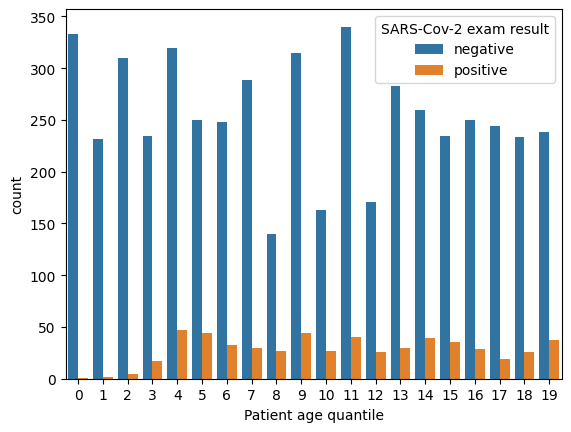

In [15]:
sns.countplot(x="Patient age quantile", hue="SARS-Cov-2 exam result", data=df)

Relation entre target/viral

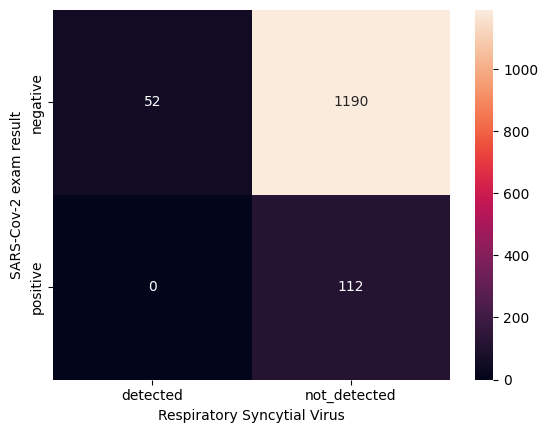

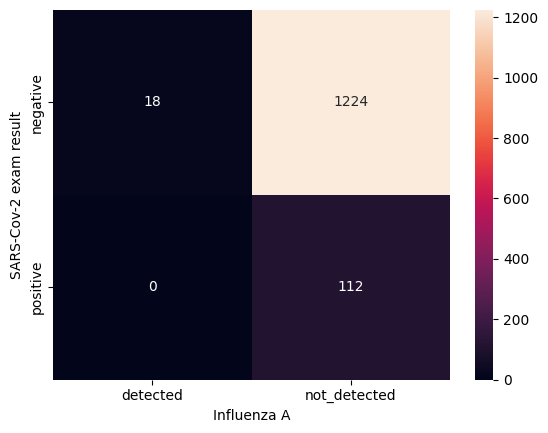

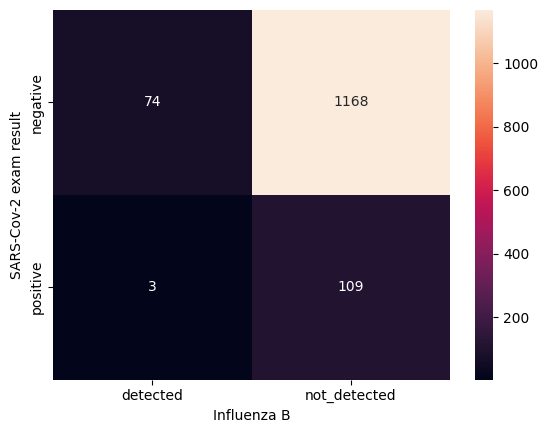

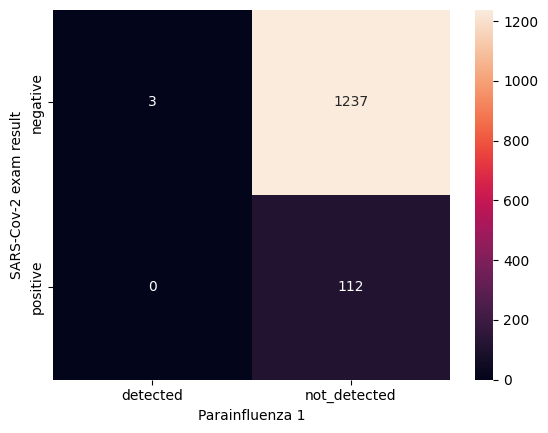

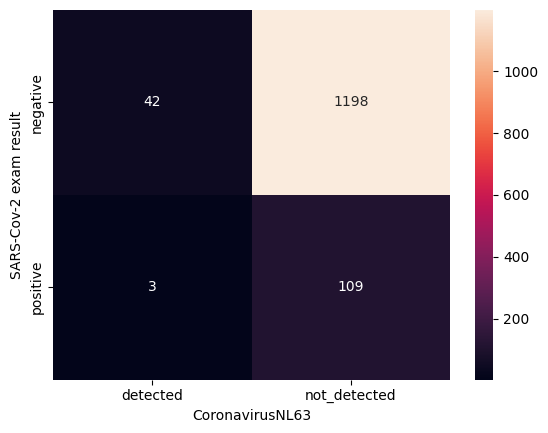

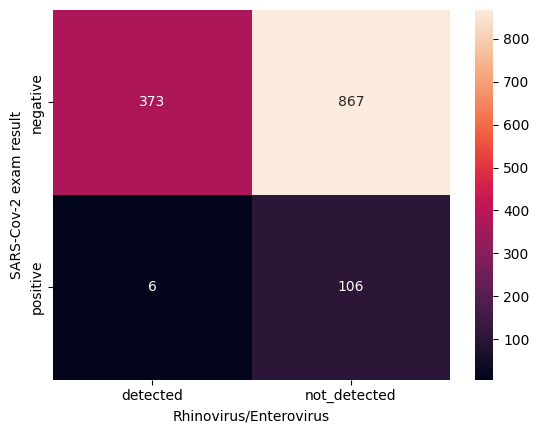

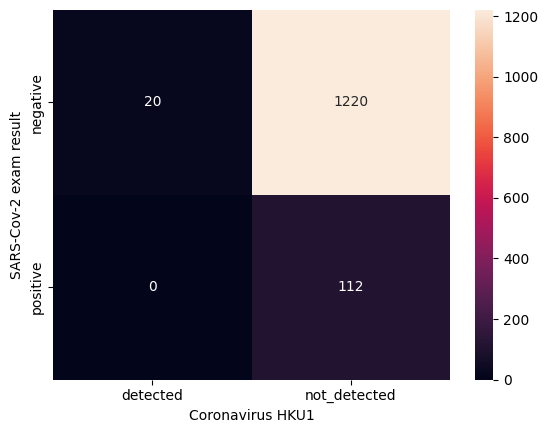

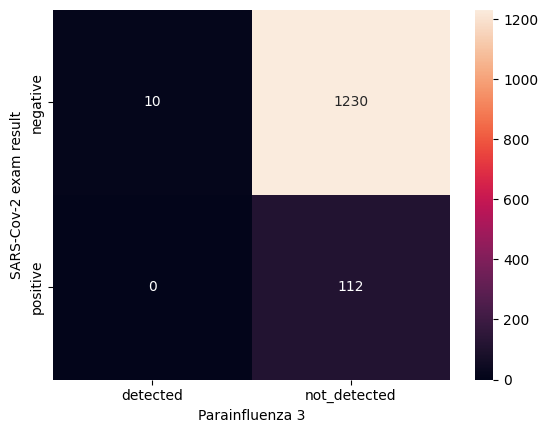

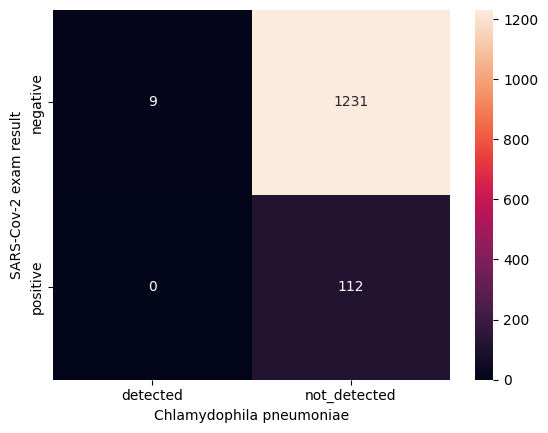

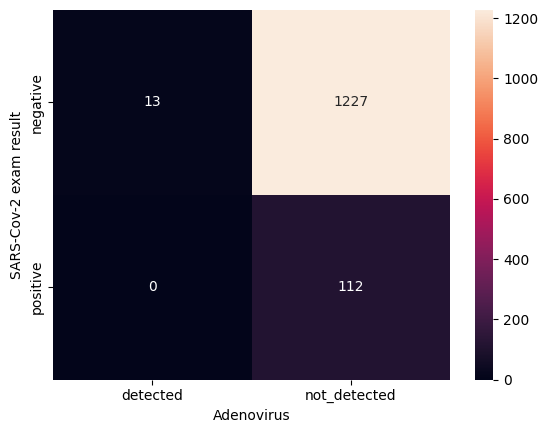

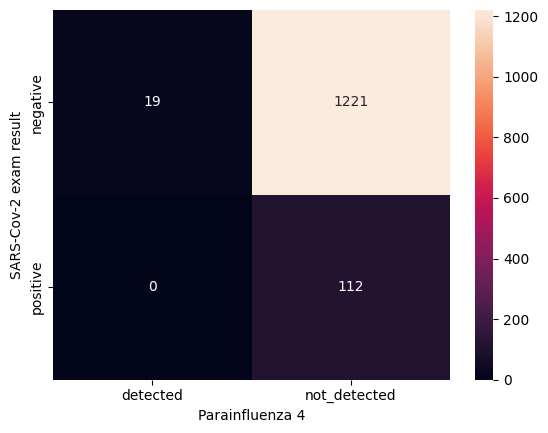

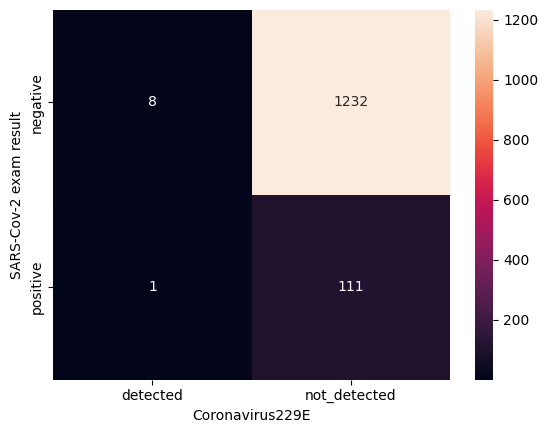

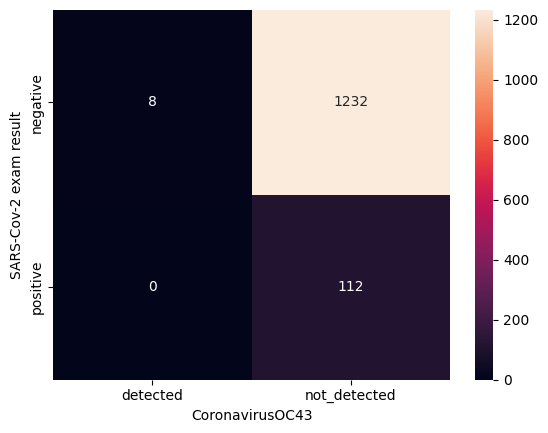

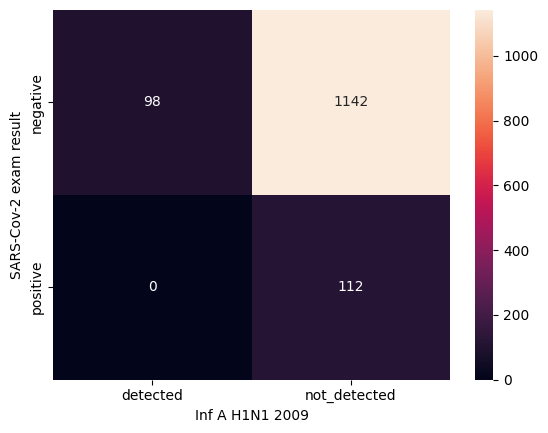

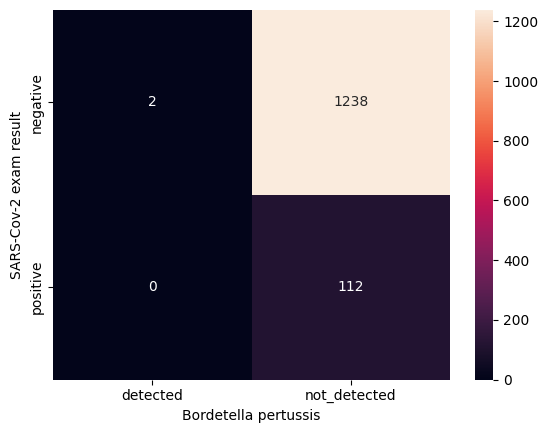

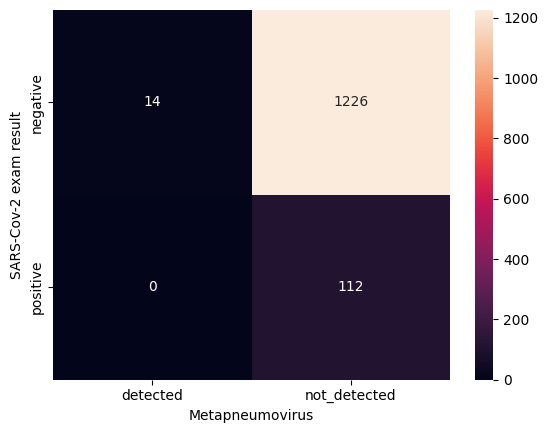

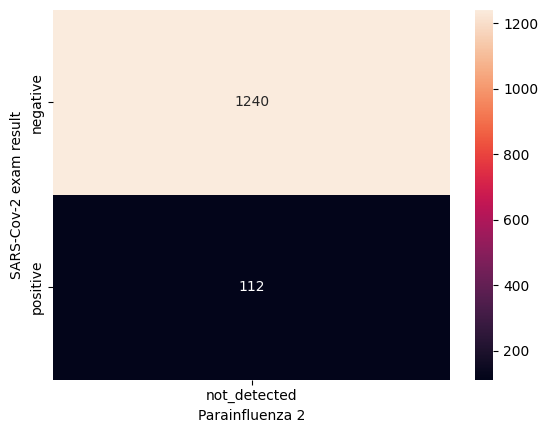

In [16]:
for col in viral_columns:
    plt.figure()
    sns.heatmap(pd.crosstab(df["SARS-Cov-2 exam result"], df[col]), annot=True, fmt="d")

### Analyse plus détaillée

#### Analyse variables/variables
- blood/blood: certaines variables très corrélées (+0.9) => à surveiller plus tard
- blood/age: : corrélation très faible
- viral/viral: Influenza rapid test (A et B) donnent de mauvais résultats => il faudra cerainement les supprimer 
- viral/blood: Relation différente que la relation target/blood. Taux sanguins entre simples malades et covid-19 sont différents
- hospitalisation/blood: intéressant dans le cas où l'on voudrait prédire dans quelle service un patient devrait aller

#### Nan analyse
viral: 1350 données présentes avec une proportion target positif/negatif 92/8, blood: 600 données propo 87/13

## Hypothèses nulle (H0)
- Les individus atteints du covid-19 ont des taux de Leukocytes, Monocytes, Platelets significativements différents
    - H0 = Les taux moyens sont EGAUX chez les individus positifs et négatifs => hypothèse rejetée ()
        - H0 rejetée pour Platelets, Red blood Cells, Leukocytes, Eosinophils, Monocytes
- Les individus atteints d'une quelconque maladie ont des taux significativement différents
    - H0 = Les individus atteints d'une maladie n'ont pas de taux sanguins significativement différents
        - H0 rejetée pour Leukocytes, Hemoglobin

**Tips**:
- sns.pairplot
- sns.heatmap
- sns.clustermap
- deux variables que l'on compare avec une autre grâce à histplot

Blood/Blood

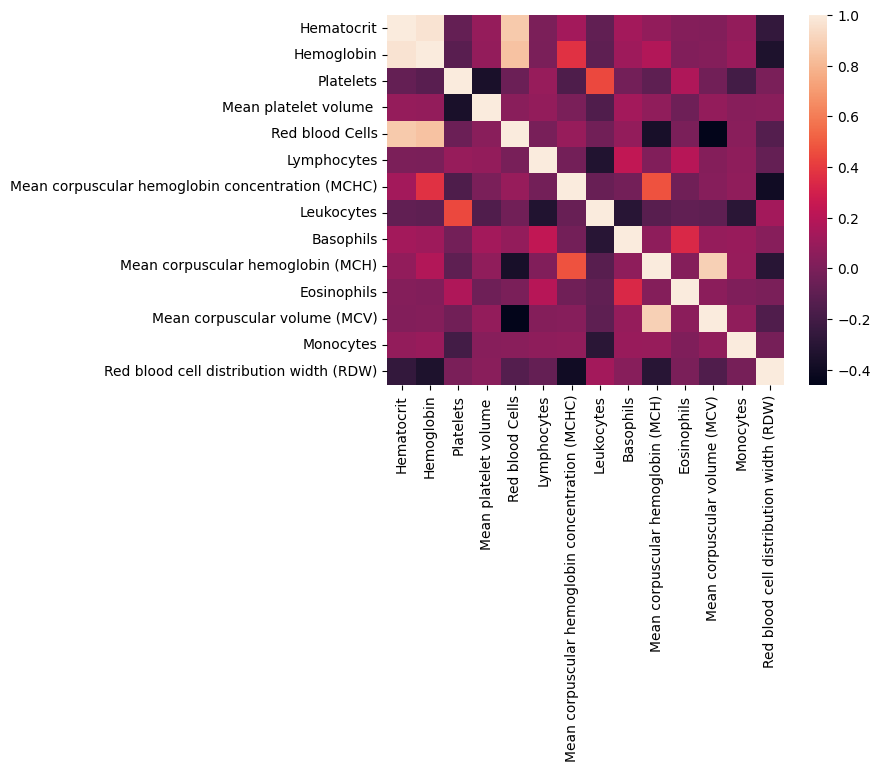

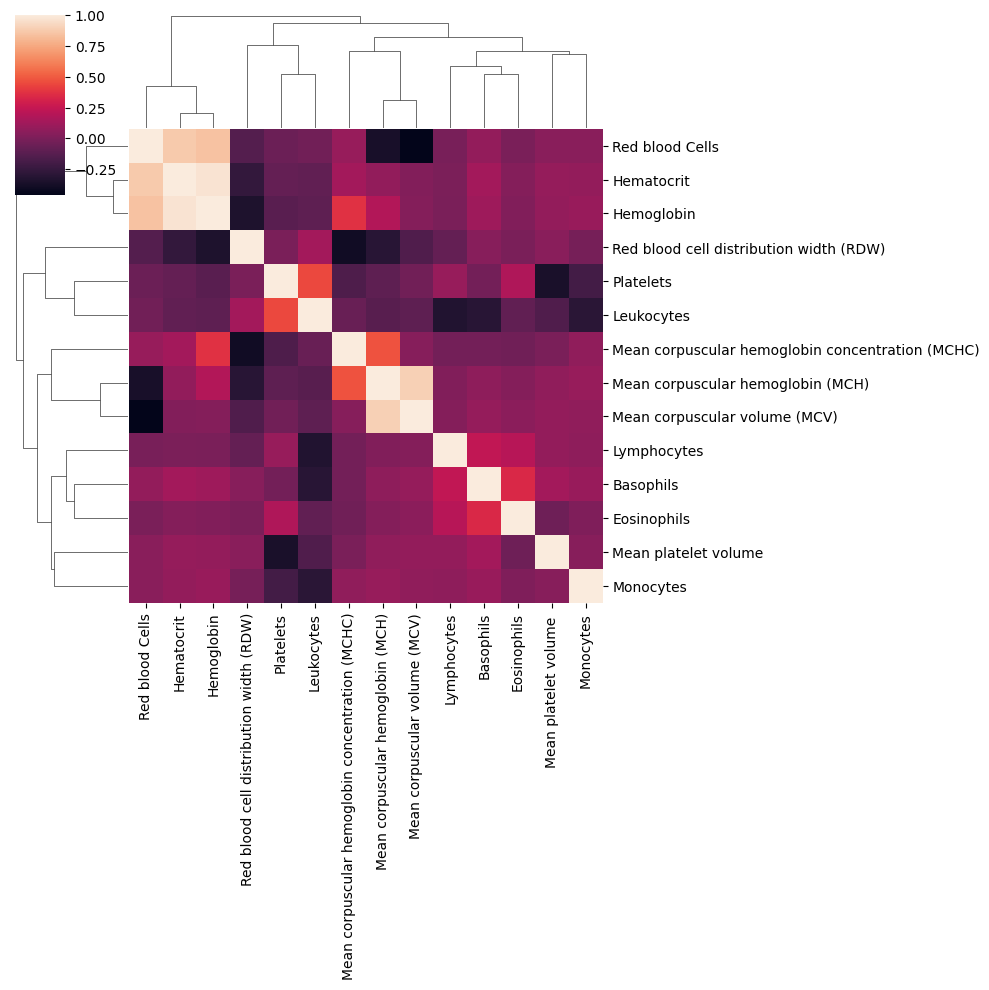

In [17]:
#sns.pairplot(df[blood_columns])
sns.heatmap(df[blood_columns].corr())
sns.clustermap(df[blood_columns].corr())

blood/age

C:\Users\Jules\AppData\Local\Temp\ipykernel_13096\3840394934.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


<Figure size 640x480 with 0 Axes>

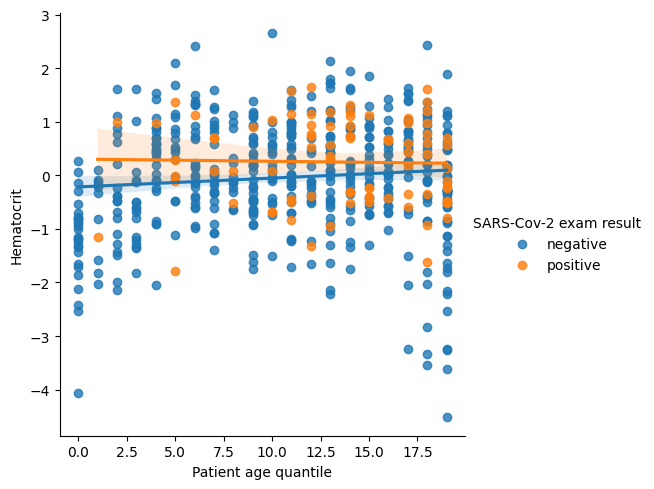

<Figure size 640x480 with 0 Axes>

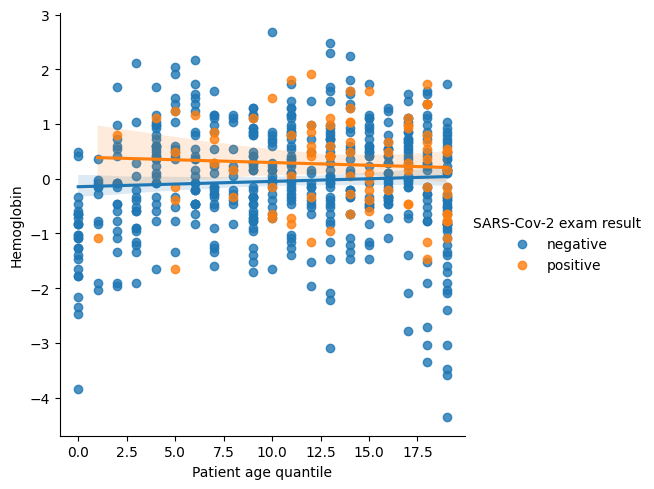

<Figure size 640x480 with 0 Axes>

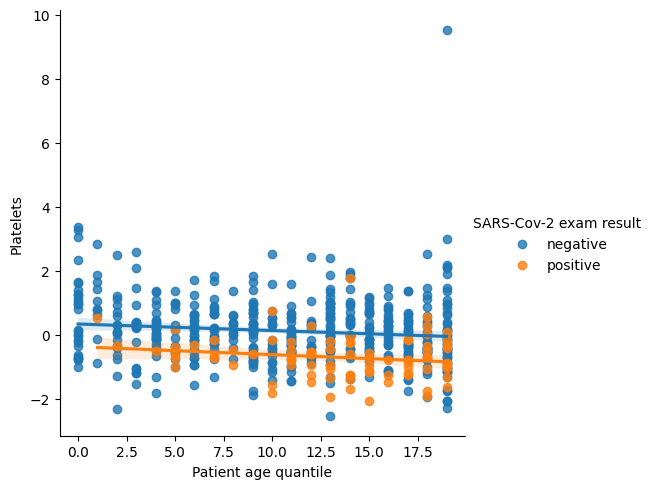

<Figure size 640x480 with 0 Axes>

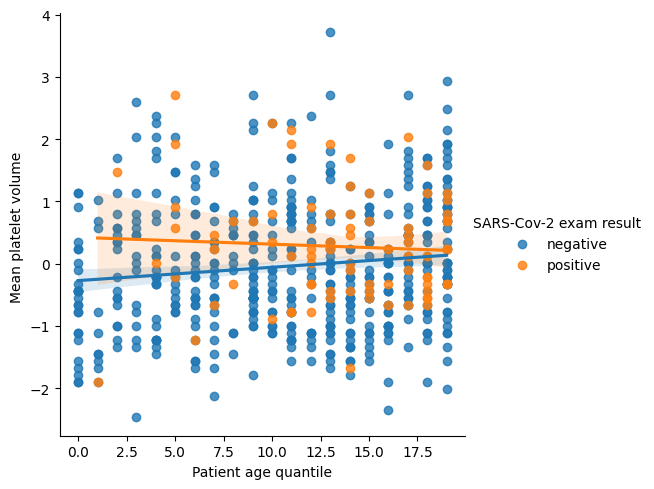

<Figure size 640x480 with 0 Axes>

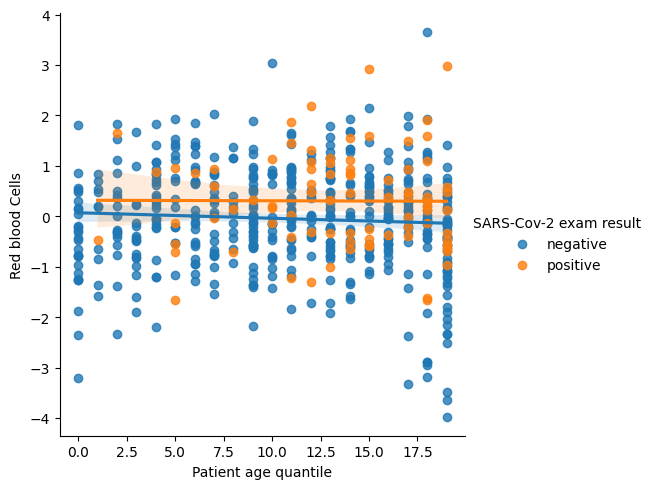

<Figure size 640x480 with 0 Axes>

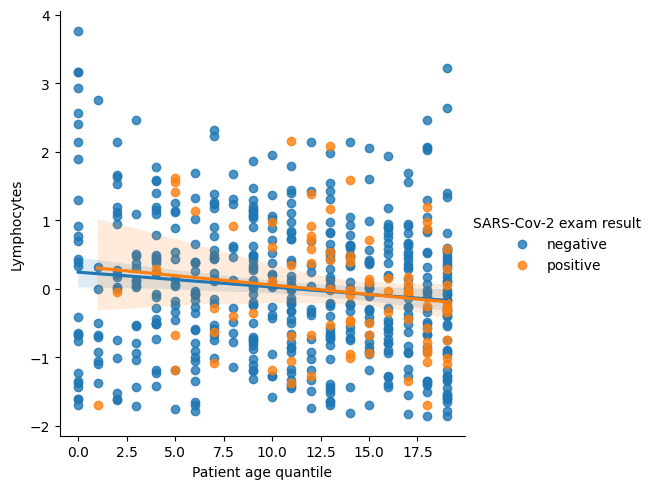

<Figure size 640x480 with 0 Axes>

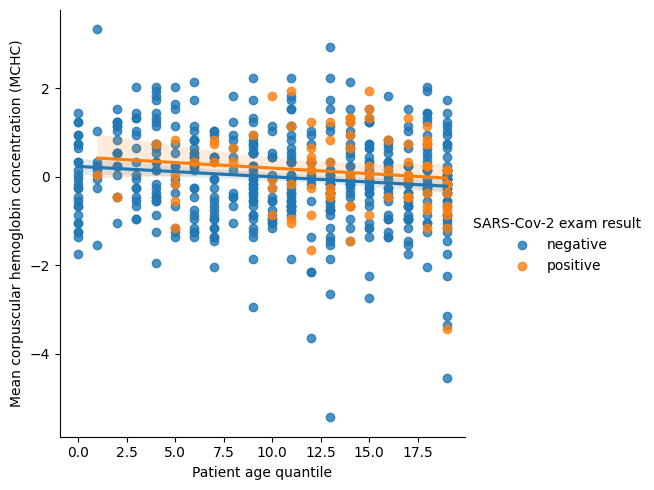

<Figure size 640x480 with 0 Axes>

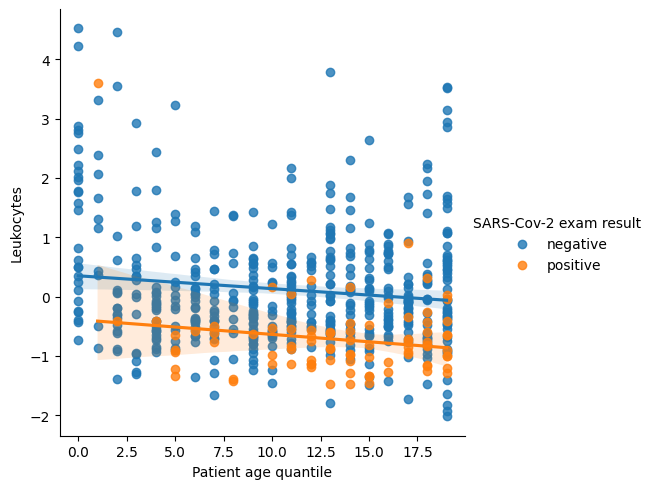

<Figure size 640x480 with 0 Axes>

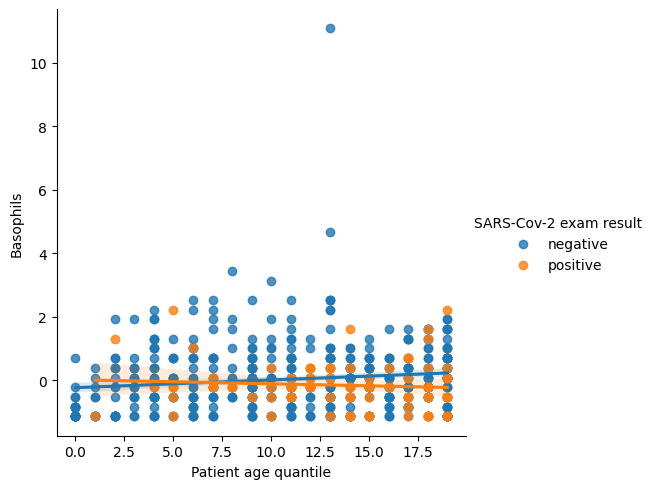

<Figure size 640x480 with 0 Axes>

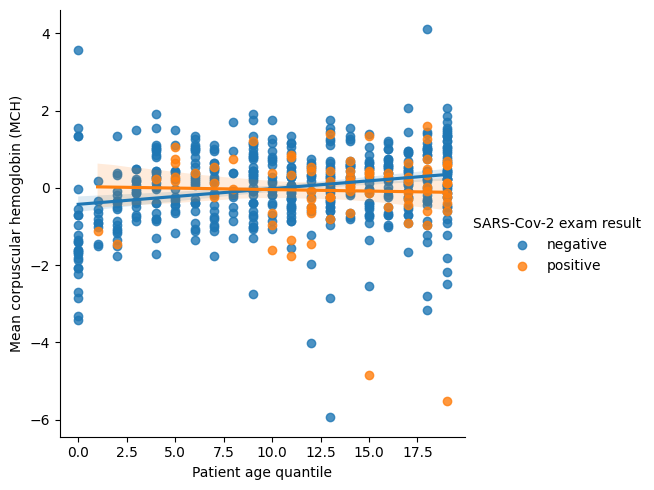

<Figure size 640x480 with 0 Axes>

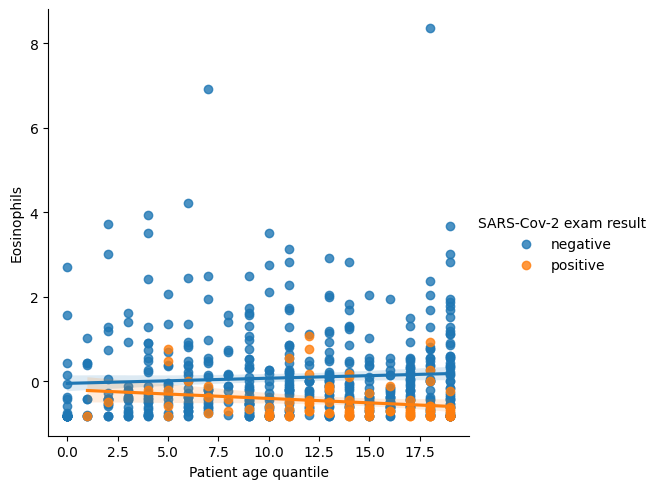

<Figure size 640x480 with 0 Axes>

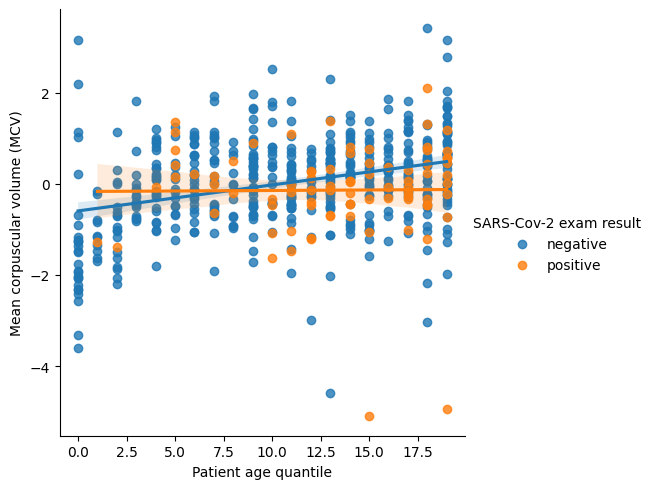

<Figure size 640x480 with 0 Axes>

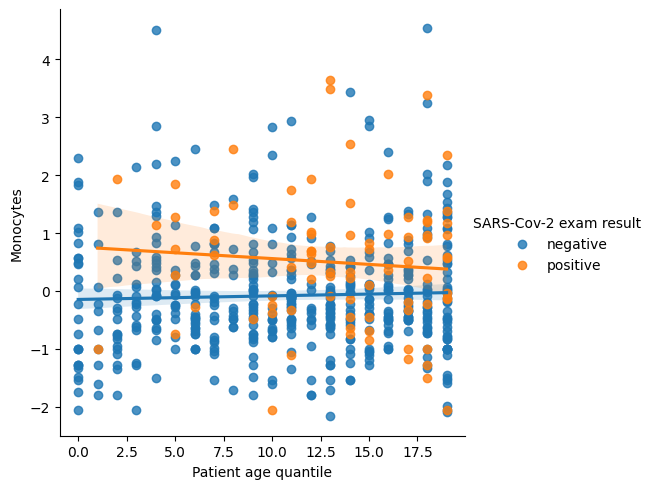

<Figure size 640x480 with 0 Axes>

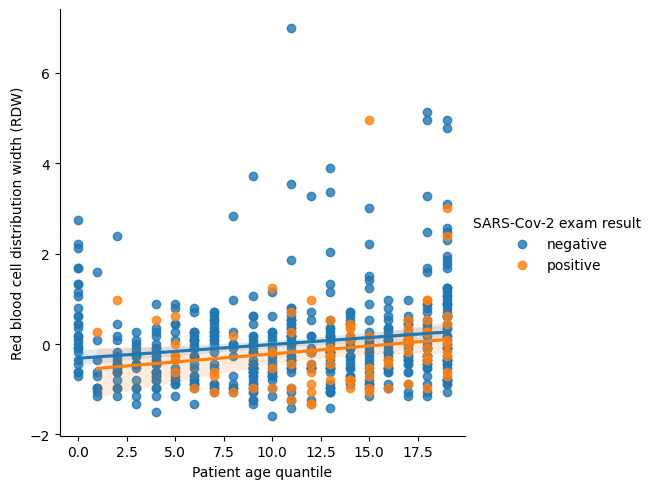

In [18]:
for col in blood_columns:
    plt.figure()
    sns.lmplot(x="Patient age quantile", y=col, hue="SARS-Cov-2 exam result", data=df) # => pas de corrélation linéaire

In [19]:
df_blood_columns_and_age = df[blood_columns]
df_blood_columns_and_age["Patient age quantile"] = df["Patient age quantile"]
df_blood_columns_and_age.corr()["Patient age quantile"].sort_values()

C:\Users\Jules\AppData\Local\Temp\ipykernel_13096\1520281973.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_blood_columns_and_age["Patient age quantile"] = df["Patient age quantile"]


Leukocytes                                         -0.166386
Platelets                                          -0.158683
Lymphocytes                                        -0.125935
Mean corpuscular hemoglobin concentration (MCHC)   -0.124671
Red blood Cells                                    -0.037510
Eosinophils                                         0.022085
Monocytes                                           0.050962
Hemoglobin                                          0.060320
Hematocrit                                          0.096808
Basophils                                           0.107525
Mean platelet volume                                0.119449
Red blood cell distribution width (RDW)             0.166429
Mean corpuscular hemoglobin (MCH)                   0.197394
Mean corpuscular volume (MCV)                       0.281655
Patient age quantile                                1.000000
Name: Patient age quantile, dtype: float64

Relation entre Influenza et rapid test

In [20]:
display(pd.crosstab(df["Influenza A"], df["Influenza A, rapid test"])) # Tests peu confiants
display(pd.crosstab(df["Influenza B"], df["Influenza B, rapid test"]))

Influenza A, rapid test  negative  positive
Influenza A                                
detected                        2         4
not_detected                  245        15

Influenza B, rapid test  negative  positive
Influenza B                                
detected                       18        11
not_detected                  233         4

Reation viral/sanguin

In [21]:
#Création d'une variable "malade" qui compte le nombre de virus détectés pour chaque patient
df["malade"] = np.sum(df[viral_columns[:-2]] == "detected", axis=1)
#Création de deux variables "malade_df" et "non_malade_df" qui contiennent respectivement les patients malades et non malades
malade_df = df[df["malade"] > 0]
non_malade_df = df[df["malade"] == 0]

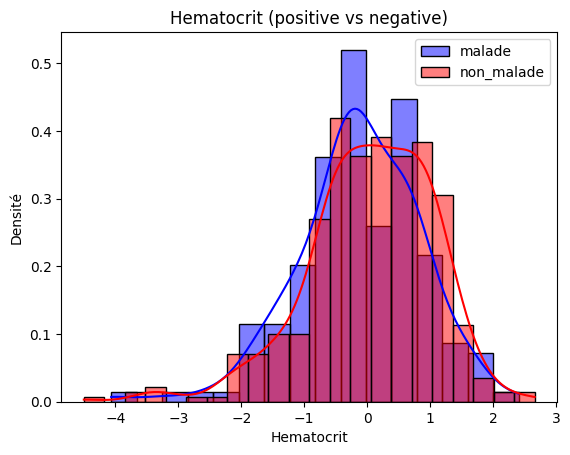

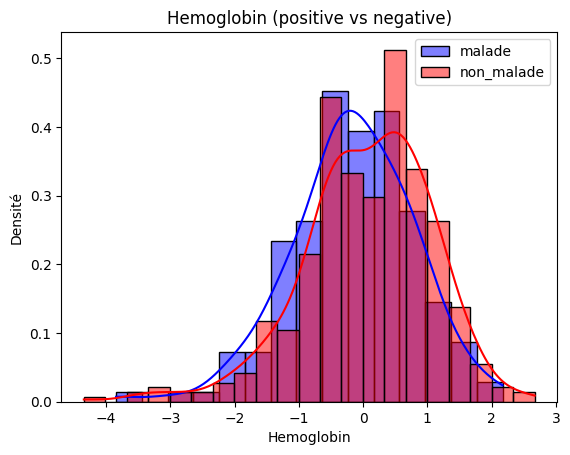

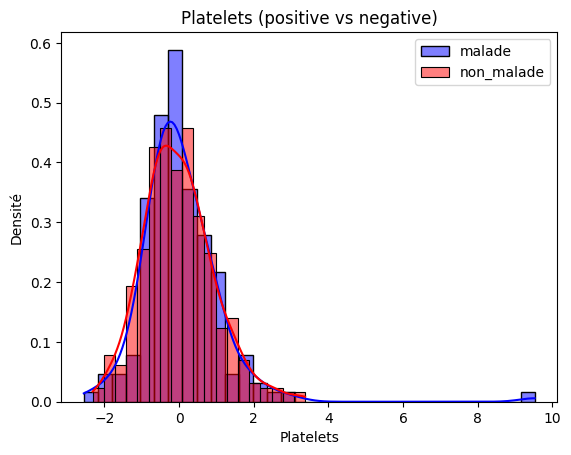

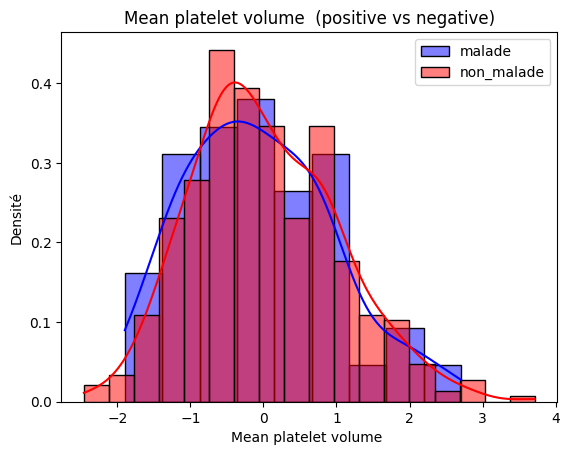

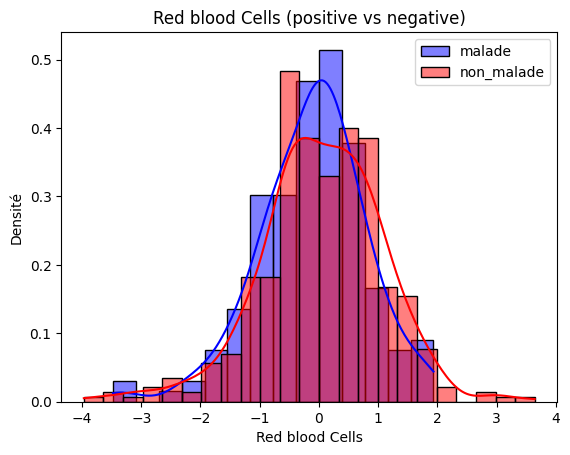

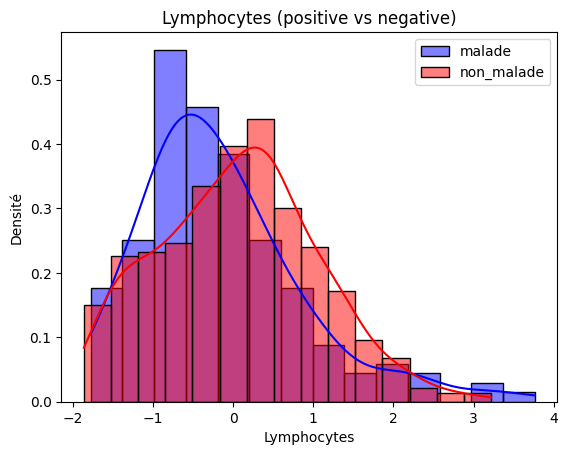

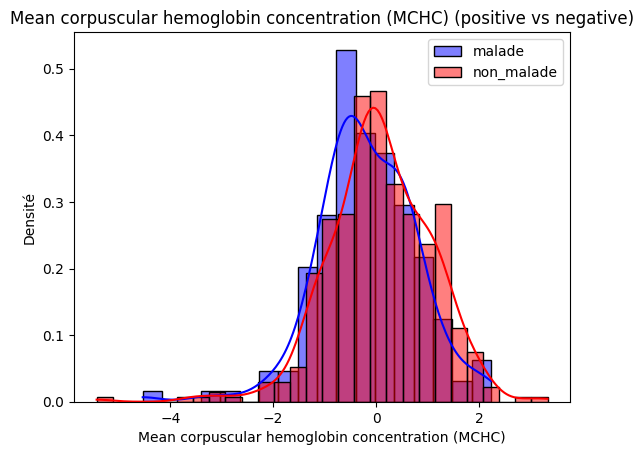

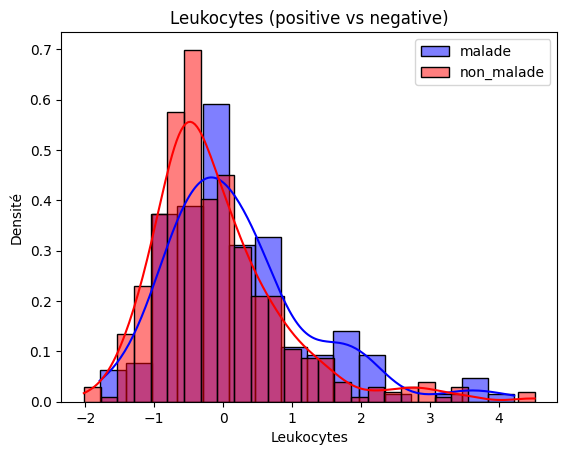

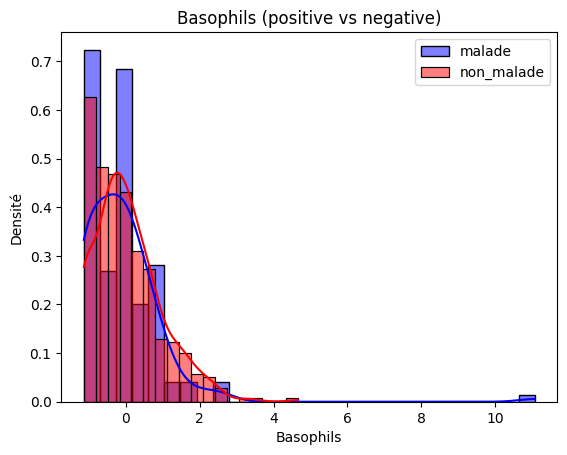

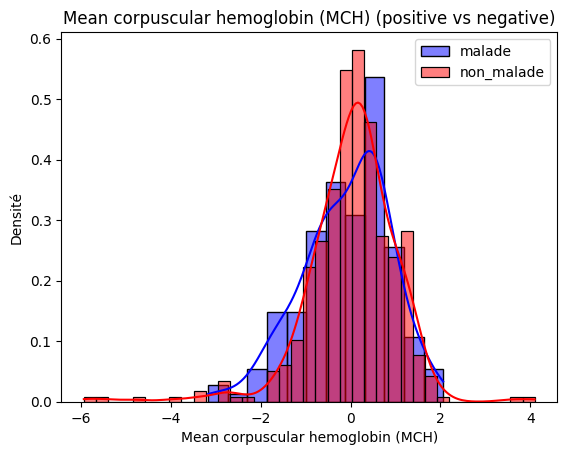

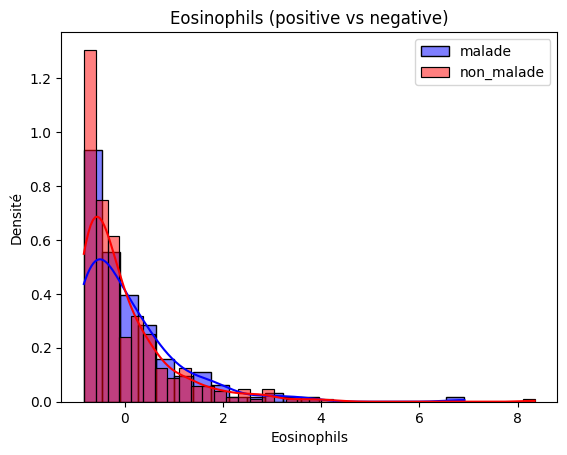

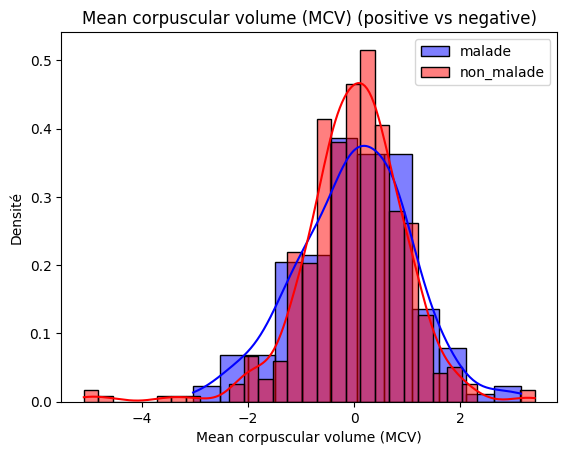

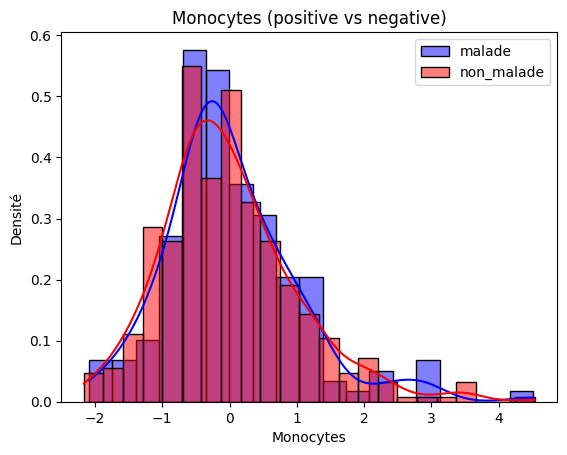

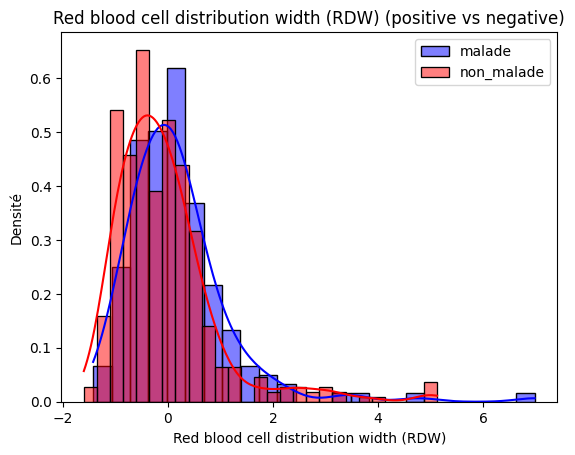

In [22]:
for col in blood_columns:
    plt.figure()
    sns.histplot(malade_df[col], label="malade", kde=True, alpha=0.5, color="blue", stat="density")
    sns.histplot(non_malade_df[col], label="non_malade", kde=True, alpha=0.5, color="red", stat="density")
    plt.legend()
    plt.title(f"{col} (positive vs negative)")
    plt.ylabel("Densité")
    plt.show()

Hospitalisation/blood

In [23]:
def hospitalisation(df):
    if df["Patient addmited to regular ward (1=yes, 0=no)"] == 1:
        return "surveillance"
    elif df["Patient addmited to semi-intensive unit (1=yes, 0=no)"] == 1:
        return "semi-intensive"
    elif df["Patient addmited to intensive care unit (1=yes, 0=no)"] == 1:
        return "intensive"
    else:
        return "no_hospitalisation"
    

In [24]:
df["statut"] = df.apply(hospitalisation, axis=1)
df["statut"].value_counts()
df["statut"].unique()

array(['no_hospitalisation', 'semi-intensive', 'surveillance',
       'intensive'], dtype=object)

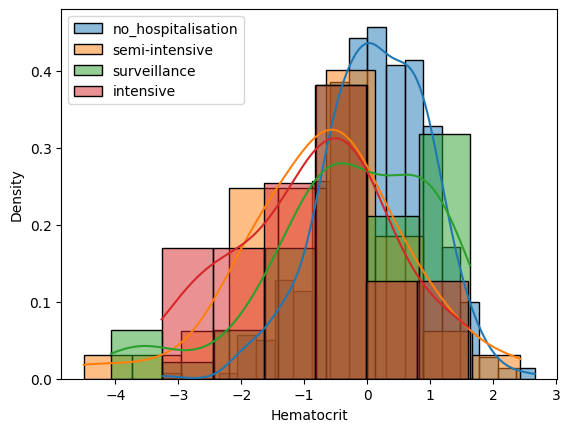

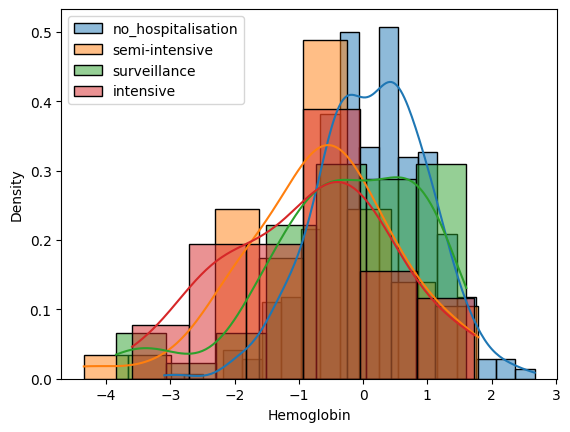

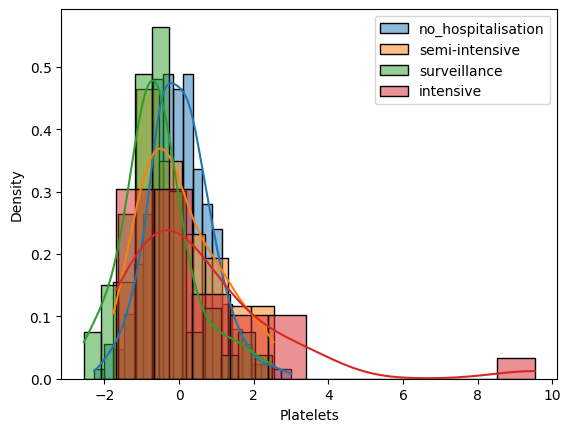

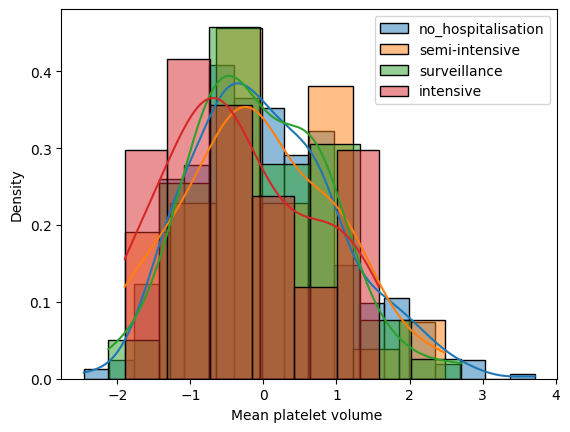

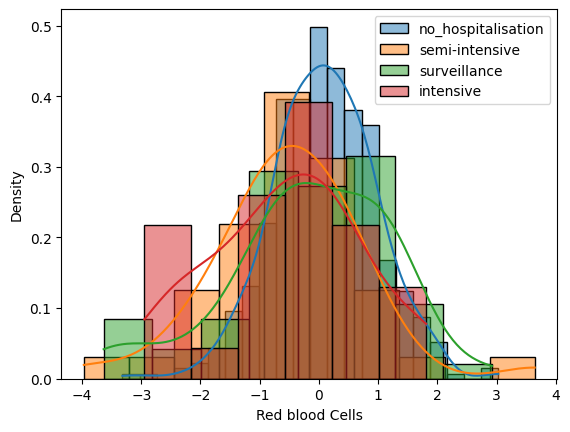

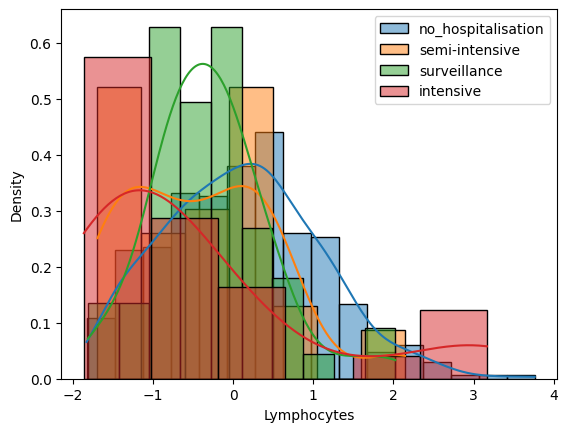

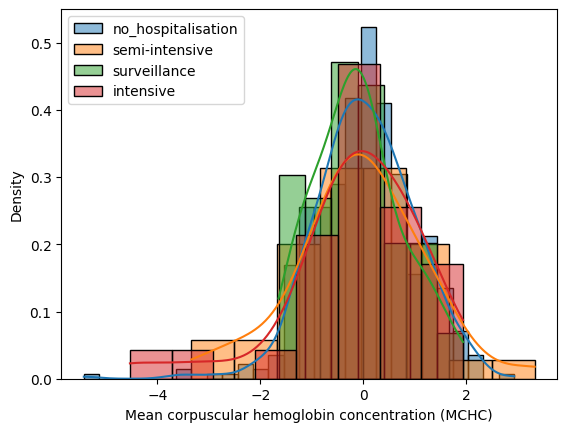

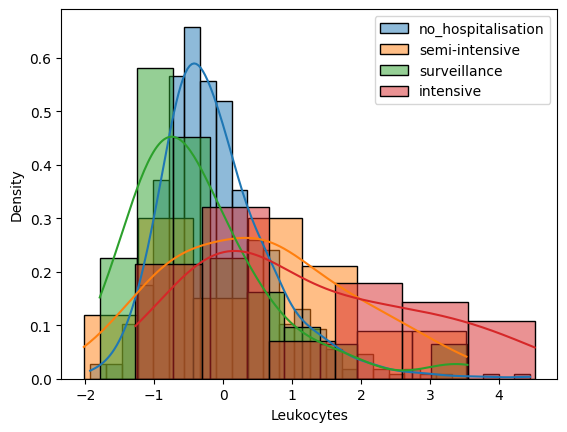

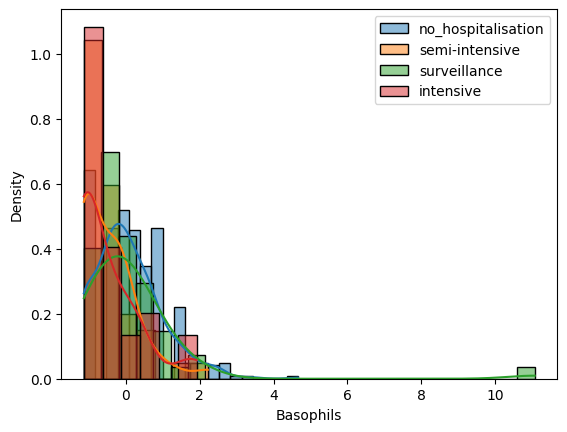

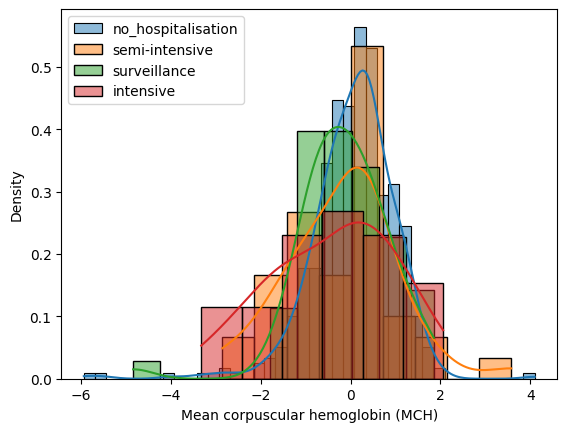

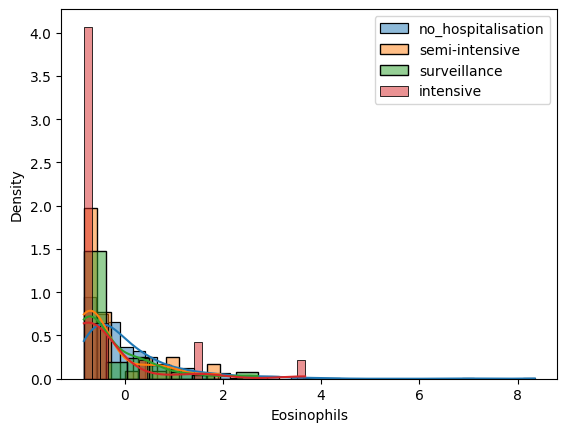

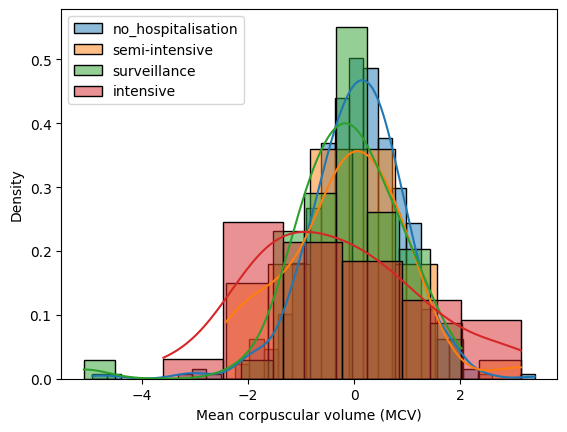

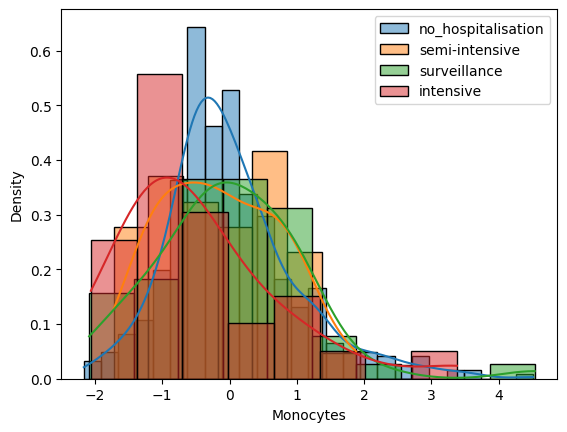

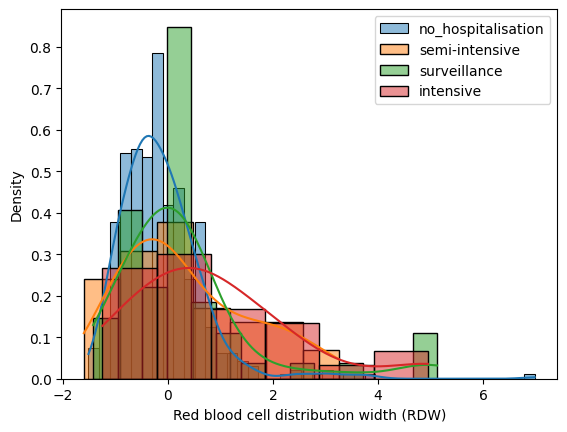

In [25]:
for col in blood_columns:
    plt.figure()
    for cat in df["statut"].unique():
        sns.histplot(df[df["statut"] == cat][col], label=cat, kde=True, alpha=0.5, stat="density")
    plt.legend() 

In [26]:
# Si on ne travail qu'avec les colonnes sanguines
print(df[blood_columns].count())
# Si on ne travail qu'avec les colonnes virales
print(df[viral_columns].count())

Hematocrit                                          603
Hemoglobin                                          603
Platelets                                           602
Mean platelet volume                                599
Red blood Cells                                     602
Lymphocytes                                         602
Mean corpuscular hemoglobin concentration (MCHC)    602
Leukocytes                                          602
Basophils                                           602
Mean corpuscular hemoglobin (MCH)                   602
Eosinophils                                         602
Mean corpuscular volume (MCV)                       602
Monocytes                                           601
Red blood cell distribution width (RDW)             602
dtype: int64
Respiratory Syncytial Virus    1354
Influenza A                    1354
Influenza B                    1354
Parainfluenza 1                1352
CoronavirusNL63                1352
Rhinovirus/Enterovirus 

### T-Test

    - H0 = Les taux moyens sont EGAUX chez les individus positifs et négatifs => hypothèse rejetée ()

In [27]:

balanced_neg = negative_df.sample(positive_df.shape[0], random_state=42)

def t_test(col):
    alpha = 0.02
    stat, p = ttest_ind(balanced_neg[col].dropna(), positive_df[col].dropna())
    if p < alpha:
        return 'H0 rejetée'
    else:
        return 0
for col in blood_columns:
    print(f"{col :-<50} : {t_test(col)}")

Hematocrit---------------------------------------- : 0
Hemoglobin---------------------------------------- : 0
Platelets----------------------------------------- : H0 rejetée
Mean platelet volume ----------------------------- : 0
Red blood Cells----------------------------------- : H0 rejetée
Lymphocytes--------------------------------------- : 0
Mean corpuscular hemoglobin concentration (MCHC)-- : 0
Leukocytes---------------------------------------- : H0 rejetée
Basophils----------------------------------------- : 0
Mean corpuscular hemoglobin (MCH)----------------- : 0
Eosinophils--------------------------------------- : H0 rejetée
Mean corpuscular volume (MCV)--------------------- : 0
Monocytes----------------------------------------- : H0 rejetée
Red blood cell distribution width (RDW)----------- : 0


    - H0 = Les individus atteints d'une maladie n'ont pas de taux sanguins significativement différents

In [28]:
print(f"Shape de malade_df : {malade_df.shape}, Shape de non_malade_df : {non_malade_df.shape}")

balanced_non_malade = non_malade_df.sample(malade_df.shape[0], random_state=42)

def t_test(col):
    alpha = 0.02
    stat, p = ttest_ind(balanced_non_malade[col].dropna(), malade_df[col].dropna())
    if p < alpha:
        return 'H0 rejetée'
    else:
        return 0

for col in blood_columns:
    print(f"{col :-<50} : {t_test(col)}")

Shape de malade_df : (680, 39), Shape de non_malade_df : (4964, 39)
Hematocrit---------------------------------------- : 0
Hemoglobin---------------------------------------- : H0 rejetée
Platelets----------------------------------------- : 0
Mean platelet volume ----------------------------- : 0
Red blood Cells----------------------------------- : 0
Lymphocytes--------------------------------------- : 0
Mean corpuscular hemoglobin concentration (MCHC)-- : 0
Leukocytes---------------------------------------- : H0 rejetée
Basophils----------------------------------------- : 0
Mean corpuscular hemoglobin (MCH)----------------- : 0
Eosinophils--------------------------------------- : 0
Mean corpuscular volume (MCV)--------------------- : 0
Monocytes----------------------------------------- : 0
Red blood cell distribution width (RDW)----------- : 0


# PRE_PROCESSING

**Tips**: 
- créer une nouvelle copie du dataframe

In [94]:
df1 = data.copy()

### Création des sous-ensembles (créés pour l'EDA)

In [95]:
missing_rate = df1.isna().sum() / df1.shape[0]
blood_columns = df1.columns[(missing_rate < 0.90) & (missing_rate > 0.89)]
viral_columns = df1.columns[(missing_rate < 0.77) & (missing_rate > 0.76)]

Création d'une liste de colonnes importantes

In [96]:
key_columns = ["Patient age quantile", "SARS-Cov-2 exam result"]

Création du nouveau df (df1) ne comprenant que les colonnes virales, sanguines et les colonnes importantes (key_columns)

In [97]:
df1 = df1[key_columns + list(blood_columns)+ list(viral_columns)] 
df1.head()

Patient age quantile SARS-Cov-2 exam result  Hematocrit  Hemoglobin  \
0                    13               negative         NaN         NaN   
1                    17               negative    0.236515    -0.02234   
2                     8               negative         NaN         NaN   
3                     5               negative         NaN         NaN   
4                    15               negative         NaN         NaN   

   Platelets  Mean platelet volume   Red blood Cells  Lymphocytes  \
0        NaN                    NaN              NaN          NaN   
1  -0.517413               0.010677         0.102004     0.318366   
2        NaN                    NaN              NaN          NaN   
3        NaN                    NaN              NaN          NaN   
4        NaN                    NaN              NaN          NaN   

   Mean corpuscular hemoglobin concentration (MCHC)  Leukocytes  ...  \
0                                               NaN         NaN  ...   
1                                          -0.95079    -0.09461  ...   
2                                               NaN         NaN  ...   
3                                               NaN         NaN  ...   
4                                               NaN         NaN  ...   

   Parainfluenza 3  Chlamydophila pneumoniae    Adenovirus  Parainfluenza 4  \
0              NaN                       NaN           NaN              NaN   
1     not_detected              not_detected  not_detected     not_detected   
2              NaN                       NaN           NaN              NaN   
3              NaN                       NaN           NaN              NaN   
4     not_detected              not_detected  not_detected     not_detected   

   Coronavirus229E  CoronavirusOC43 Inf A H1N1 2009 Bordetella pertussis  \
0              NaN              NaN             NaN                  NaN   
1     not_detected     not_detected    not_detected         not_detected   
2              NaN              NaN             NaN                  NaN   
3              NaN              NaN             NaN                  NaN   
4     not_detected     not_detected    not_detected         not_detected   

  Metapneumovirus Parainfluenza 2  
0             NaN             NaN  
1    not_detected    not_detected  
2             NaN             NaN  
3             NaN             NaN  
4    not_detected    not_detected  

[5 rows x 33 columns]

## Split - Nettoyage - Encodage

### Split

In [98]:
train_set, test_set = train_test_split(df1, test_size=0.2, random_state=0)

Vérification du pourcentage de positifs dans chacun des sets

In [99]:
print(train_set["SARS-Cov-2 exam result"].value_counts()) # Bien 10%
print(test_set["SARS-Cov-2 exam result"].value_counts()) # Bien 10%

SARS-Cov-2 exam result
negative    4068
positive     447
Name: count, dtype: int64
SARS-Cov-2 exam result
negative    1018
positive     111
Name: count, dtype: int64


### Encodage

Amusement sérieux, retourne les type de valeurs dans les objets

In [100]:
def get_unique_object_values(df):
    type_object_list = []
    
    for col in df.columns:
        for value in df[col].unique():
            if isinstance(value, str):  # ✅ Test si c'est une chaîne
                print(f"Colonne: {col}, Valeur unique: {value}")
            if value not in type_object_list:
                type_object_list.append(value)

    
    return type_object_list

print(get_unique_object_values(train_set))

Colonne: SARS-Cov-2 exam result, Valeur unique: negative
Colonne: SARS-Cov-2 exam result, Valeur unique: positive
Colonne: Respiratory Syncytial Virus, Valeur unique: not_detected
Colonne: Respiratory Syncytial Virus, Valeur unique: detected
Colonne: Influenza A, Valeur unique: not_detected
Colonne: Influenza A, Valeur unique: detected
Colonne: Influenza B, Valeur unique: not_detected
Colonne: Influenza B, Valeur unique: detected
Colonne: Parainfluenza 1, Valeur unique: not_detected
Colonne: Parainfluenza 1, Valeur unique: detected
Colonne: CoronavirusNL63, Valeur unique: not_detected
Colonne: CoronavirusNL63, Valeur unique: detected
Colonne: Rhinovirus/Enterovirus, Valeur unique: not_detected
Colonne: Rhinovirus/Enterovirus, Valeur unique: detected
Colonne: Coronavirus HKU1, Valeur unique: not_detected
Colonne: Coronavirus HKU1, Valeur unique: detected
Colonne: Parainfluenza 3, Valeur unique: not_detected
Colonne: Parainfluenza 3, Valeur unique: detected
Colonne: Chlamydophila pneumon

In [101]:
def encodage(df):
    code = {
        "positive": 1,
        "negative": 0,
        "detected": 1,
        "not_detected": 0,
    }
    for col in df.select_dtypes("object"):
        df[col] = df[col].map(code)
    return df

In [102]:
def featutre_engineering(df):
    df["malade"] = df[viral_columns].sum(axis=1) >= 1
    df = df.drop(viral_columns, axis=1)  # On supprime les colonnes virales car on a déjà créé la variable "malade"
    #df["statut"] = df.apply(hospitalisation, axis=1) => Je ne sais pas si c'est bon
    return df

In [103]:
def imputation(df):
    #df["is na"] = df.isna().any(axis=1)  # Création d'une colonne pour savoir si une ligne a des valeurs manquantes
    #df = df.fillna(-999)
    return df.dropna(axis=0)
    #return df
    

In [104]:
def preprocessing(df):
    df = encodage(df)
    df = featutre_engineering(df)
    df = imputation(df)
    
    X = df.drop("SARS-Cov-2 exam result", axis=1)
    y = df["SARS-Cov-2 exam result"]
    print(y.value_counts())
    return X, y

In [105]:
X_train, y_train = preprocessing(train_set)

SARS-Cov-2 exam result
0    422
1     65
Name: count, dtype: int64


In [106]:
X_test, y_test = preprocessing(test_set)

SARS-Cov-2 exam result
0    95
1    16
Name: count, dtype: int64


## Modélisation

**Tips**:
- Utiliser un arbre de décisions est souvent la meilleure alternative à choisir pour la première modélisation
- Utiliser pipeline
- Utiliser polynomialfeatures

In [124]:
#model = DecisionTreeClassifier(random_state=0)
model = make_pipeline(PolynomialFeatures(2), SelectKBest(f_classif, k=10),  # Sélection des 5 meilleures caractéristiques
                      RandomForestClassifier(random_state=0)) # Transformation en pipeline

## Procédure d'évaluation

**Tips**:
- Utiliser learning curve 
- Utiliser classification_report et confusion matrix
- Utiliser feature_importances_
- Select from model

c:\Python312\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:110: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
c:\Python312\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:111: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
c:\Python312\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:110: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
c:\Python312\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:111: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


[[91  4]
 [11  5]]
              precision    recall  f1-score   support

           0       0.89      0.96      0.92        95
           1       0.56      0.31      0.40        16

    accuracy                           0.86       111
   macro avg       0.72      0.64      0.66       111
weighted avg       0.84      0.86      0.85       111



c:\Python312\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:110: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
c:\Python312\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:111: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
c:\Python312\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:110: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
c:\Python312\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:111: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
c:\Python312\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:110: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
c:\Python312\Lib\site-packages\sklearn\feature_selection\_univa

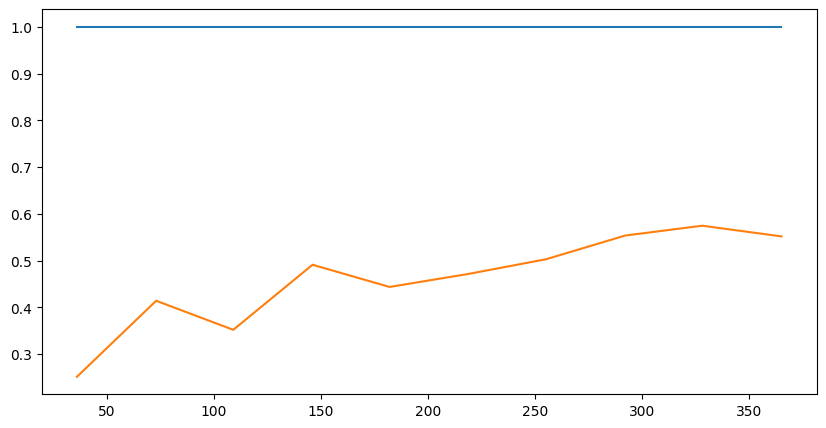

In [125]:
def evaluation(model):
    model.fit(X_train, y_train)
    ypred = model.predict(X_test)
    
    print(confusion_matrix(y_test, ypred))
    print(classification_report(y_test, ypred))
    
    N, train_score, val_score = learning_curve(model, X_train, y_train, cv=4, 
                                               train_sizes=np.linspace(0.1, 1.0, 10), scoring="f1")
    plt.figure(figsize=(10, 5))
    plt.plot(N, train_score.mean(axis=1), label="Train score")
    plt.plot(N, val_score.mean(axis=1), label="Train score")

evaluation(model)

**Conclusion1**: On peut voir un très grand over fitting + On peut voir une légère tendance haussière => peut être vouloir plus de données => changer notre imputer
=> FINALEMENT ca ne fonctionne pas, on abandonne

**Conclusion2**: Toujours de l'overfitting donc changer modèle + réintégration des données virales

Création d'un dataframe mettant en évidence les variables les plus importantes pour l'arbre de décision

<Axes: title={'center': 'Importance des variables'}>

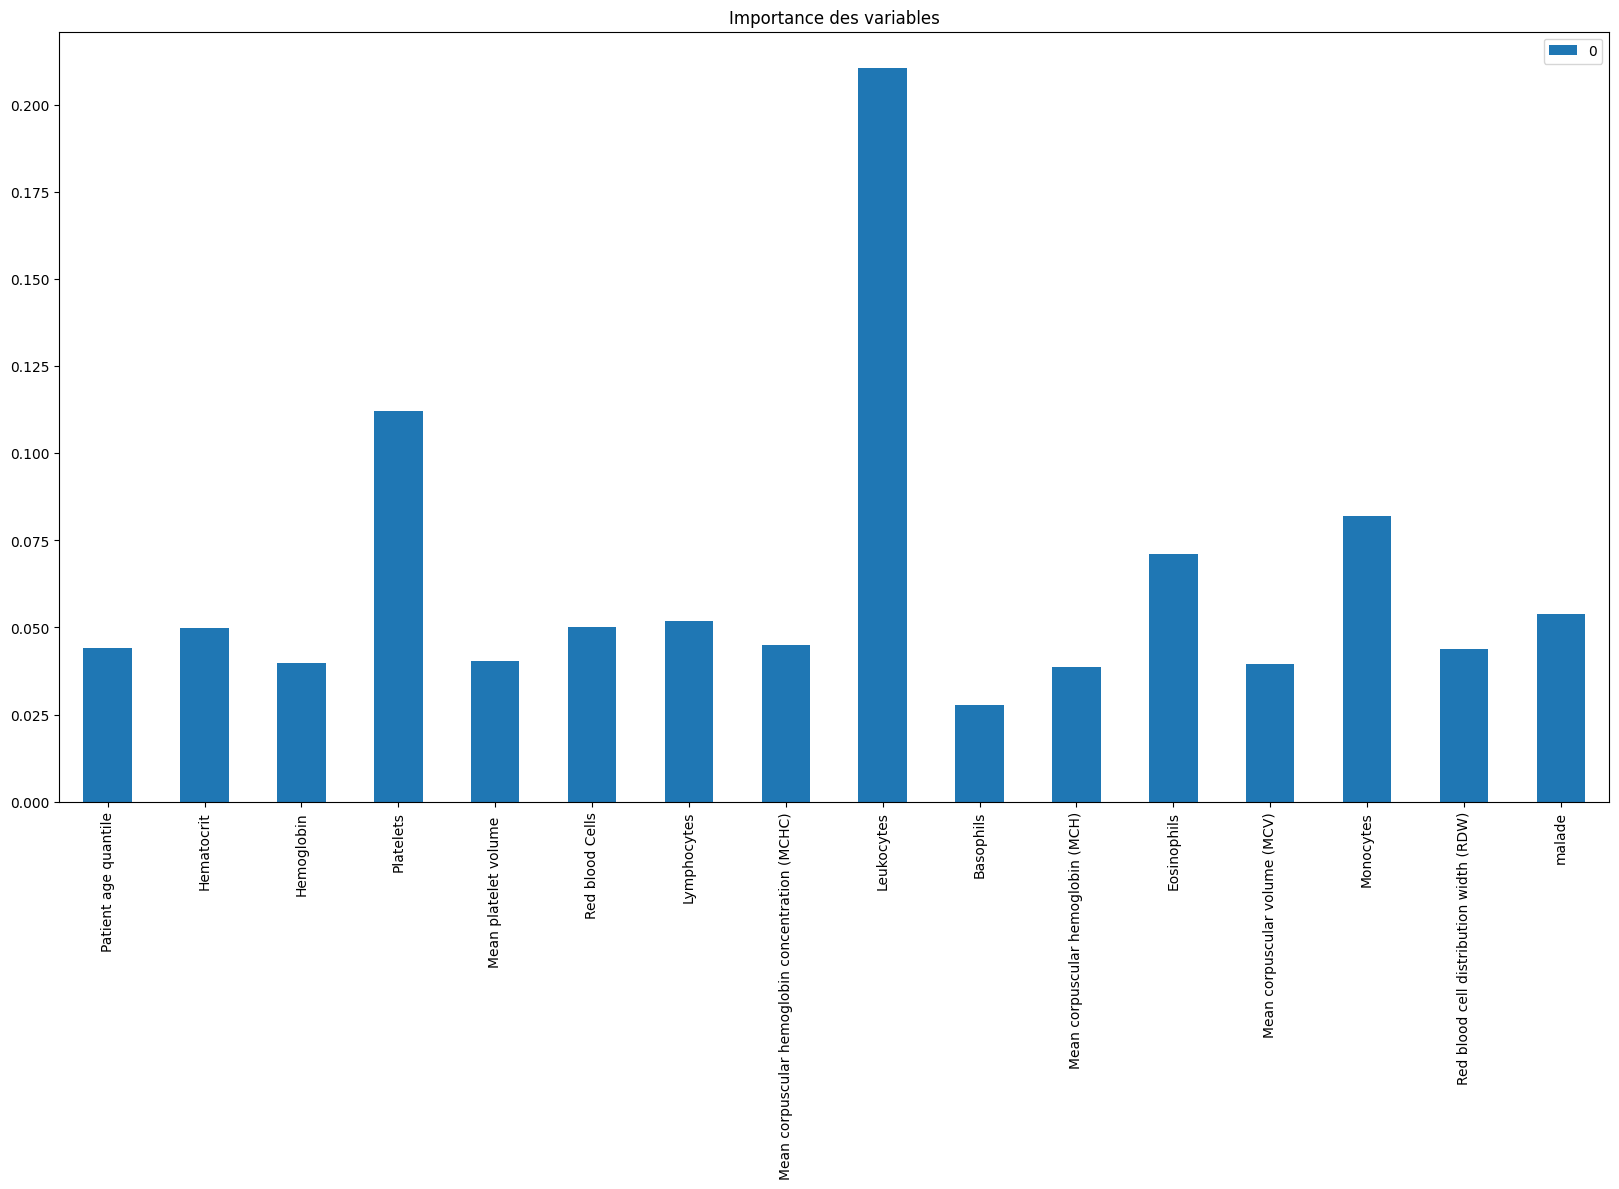

In [109]:
important_features = pd.DataFrame(model.feature_importances_, index=X_train.columns)
important_features.plot.bar(figsize=(20, 10), title="Importance des variables")

**Conclusion**: On peut voir que les colonnes virales sont pour la plupart non significativement importantes => Suppretion de ces colonnes => Peut-être augmentation du nombre de données utilisables
!! Ces conslusions ont lieu avant le changement des données. Il se peut qu'il n'ait pas de rapport avec les données présentes actuellement

**Conclusion